In [ ]:
# -*- coding: utf-8 -*-
"""
Neurocomputational Simulation for:
"Balancing behavioral flexibility and stability by parallel circuits in the posterior parietal cortex"

This script simulates a hierarchical neural network (IC -> AC -> Action) modulated by
parallel Posterior Parietal Cortex (PPC) circuits to investigate reversal learning dynamics.

Author: Woochul Choi, PhD, Senior Researcher, Korea Brain Research Institute (KBRI)
"""

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Set device and precision
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float32)
print(f"[INFO] Simulation running on: {device}")

SAVE_FLAG = True
# =========================================
# 1. Configuration & Hyperparameters
# =========================================
class SimConfig:
    # Network Dimensions
    IN_DIM = 100        # Auditory input dimension
    H_IC = 100          # Hidden units in IC
    H_AC = 100          # Hidden units in AC
    OUT_DIM = 2         # Lick vs No-Lick
    H_PPC = 100         # Neurons in PPC sub-modules

    # Stimulus Parameters
    BATCH_SIZE = 256
    STIM_MU = 2.0
    STIM_SIGMA = 0.15

    # Learning Parameters
    LR_BASE = 1e-2
    LR_BOOST_IC_AC = 5.0  # Boost learning rate for IC->AC connection
    META_ALPHA = 4.0      # Sharpness of flexibility gating
    ENTROPY_BETA = 1e-3
    GRAD_CLIP = 5.0
    EMA_BETA = 0.95       # Reward baseline smoothing

    # Reinforcement Learning (RL)
    REWARD_GO = 1.0
    PENALTY_FA = -1.0
    PENALTY_NO_EVIDENCE = 2.5

    # PPC Modulation Constants
    PPC_IC_GAIN_BASE = 0.8
    PPC_IC_GAIN_SLOPE = 0.2
    PPC_AC_FLEX_MIN = 0.0003
    PPC_AC_FLEX_MAX = 0.7
    PPC_ERR_SLOPE = 2.0

    # PPC Control Params
    PPC_TARGET_ACC    = 0.6   # 목표 정답률
    PPC_SIGMOID_SLOPE = 30.0  # 전환 기울기
    # Plotting

# =========================================
# 2. Stimulus Generator
# =========================================
def generate_batch(n=128, sigma=SimConfig.STIM_SIGMA, stim_type=None):
    """Generates auditory input patterns for 5kHz or 10kHz tones."""
    X = sigma * torch.randn(n, SimConfig.IN_DIM)

    if stim_type == "5kHz":
        X[:, :SimConfig.IN_DIM//2] += SimConfig.STIM_MU
        y = torch.zeros(n, dtype=torch.long)
    elif stim_type == "10kHz":
        X[:, SimConfig.IN_DIM//2:] += SimConfig.STIM_MU
        y = torch.ones(n, dtype=torch.long)
    else:
        raise ValueError("stim_type must be '5kHz' or '10kHz'")
    return X, y

def generate_mixed_batch(n=SimConfig.BATCH_SIZE, sigma=SimConfig.STIM_SIGMA):
    """Generates a shuffled batch containing both trial types."""
    half = n // 2
    X5, y5 = generate_batch(half, sigma, "5kHz")
    X1, y1 = generate_batch(n - half, sigma, "10kHz")

    X = torch.cat([X5, X1], dim=0)
    y = torch.cat([y5, y1], dim=0)

    idx = torch.randperm(n)
    return X[idx], y[idx]

# =========================================
# 3. Hierarchical Network Model
# =========================================
class FlexStableMLP(nn.Module):
    """
    Feed-forward network: Input -> IC -> AC -> Readout
    - IC gain is modulated by PPC_IC (Stability)
    - AC plasticity is modulated by PPC_AC (Flexibility)
    """
    def __init__(self):
        super().__init__()
        # Layers
        self.Input_to_IC = nn.Linear(SimConfig.IN_DIM, SimConfig.H_IC)
        self.IC_to_AC    = nn.Linear(SimConfig.H_IC, SimConfig.H_AC)
        self.Readout_IC  = nn.Linear(SimConfig.H_IC, SimConfig.OUT_DIM)
        self.AC_to_Lick  = nn.Linear(SimConfig.H_AC, 1, bias=False)

        # Activations
        self.ic_act = nn.ReLU()
        self.ac_act = nn.LeakyReLU(0.1)

        # Initialization
        nn.init.zeros_(self.Input_to_IC.bias)
        nn.init.zeros_(self.IC_to_AC.bias)
        nn.init.zeros_(self.Readout_IC.bias)
        nn.init.kaiming_normal_(self.AC_to_Lick.weight, nonlinearity='linear')

    def forward(self, x, scale_ic=0.8, scale_ac=1.0, eps_ac2lick=0.0):
        # 1. IC Layer (Gain modulated)
        h_ic = self.ic_act(self.Input_to_IC(x)) * scale_ic
        logits_ic = self.Readout_IC(h_ic)

        # 2. AC Layer (Activity modulated)
        h_ac = self.ac_act(self.IC_to_AC(h_ic)) * scale_ac

        # 3. AC Contribution to decision (Gating)
        ac_proj = self.AC_to_Lick(h_ac).squeeze(1)
        ac_rms  = (h_ac.detach().pow(2).mean().sqrt() + 1e-6)
        ac_term = eps_ac2lick * (ac_proj / ac_rms)

        # 4. Final Decision Logits
        logits = torch.zeros(x.size(0), 2, device=x.device)
        logits[:, 0] = logits_ic[:, 0] + ac_term # Lick
        logits[:, 1] = logits_ic[:, 1]           # No-Lick

        # Heuristic penalty for Licking without strong evidence
        logits[:, 0] -= (1 - scale_ic) * SimConfig.PENALTY_NO_EVIDENCE

        gate_metric = torch.sigmoid(h_ac.abs().mean(dim=1, keepdim=True))
        return logits, gate_metric, h_ic, h_ac

# =========================================
# 4. PPC Controllers (Parallel vs. Whole)
# =========================================
class ParallelPPC:
    """
    Parallel Architecture (Proposed Model):
    - PPC_IC: Monitors Goal-directed action index -> Stabilizes IC Gain.
    - PPC_AC: Monitors Stimulus-Outcome Contingency -> Gates AC Flexibility.
    """
    def __init__(self, n_ic=SimConfig.H_PPC, n_ac=SimConfig.H_PPC):
        self.n_ic = n_ic
        self.n_ac = n_ac

        # Expectations for Reversal Learning
        self.ic_exp_goal = {1: 1.0, 2: 1.0} # Goal index is always high in expert state
        self.ac_exp_contig = {
            1: torch.tensor([1.0, 0.0, 0.0, 1.0], device=device), # Hit/CR high
            2: torch.tensor([1.0, 0.0, 0.0, 1.0], device=device), # Miss/FA high (initially)
        }

        self.goal_ema = 0.0
        self.ema_beta = 0.99

        self.target_err = 1.0 - SimConfig.PPC_TARGET_ACC
        self.sigmoid_slope = SimConfig.PPC_SIGMOID_SLOPE

    @torch.no_grad()
    def update(self, goal_signal_dummy, outcome_counts, current_rule):
        hit, miss, fa, cr = outcome_counts

        # 1. Compute Goal Index: P(Lick|Go) - P(Lick|NoGo)
        n_go, n_nogo = hit + miss, fa + cr
        p_go   = hit / (n_go   + 1e-6) if n_go > 0 else 0.0
        p_nogo = fa  / (n_nogo + 1e-6) if n_nogo > 0 else 0.0
        goal_curr = p_go - p_nogo

        # EMA smoothing
        self.goal_ema = self.ema_beta * self.goal_ema + (1.0 - self.ema_beta) * goal_curr

        # 2. PPC_IC Error (Stability Signal)
        ic_error = abs(self.ic_exp_goal[current_rule] - float(self.goal_ema))

        # 3. PPC_AC Error (Flexibility Signal)
        total = float(hit + miss + fa + cr) + 1e-6
        obs_contig = torch.tensor([hit/total, miss/total, fa/total, cr/total], device=device)
        exp_contig = self.ac_exp_contig[current_rule]
        ac_error = torch.abs(obs_contig - exp_contig).mean()

        # 4. Calculate Modulation Signals
        # AC Flexibility increases with contingency error

        logit = self.sigmoid_slope * (ac_error - self.target_err)
        ac_flex = torch.sigmoid(logit)

        # IC Gain decreases with goal error (Stabilization)
        # Note: Logic here is 0.8 + 0.2 * error, but clipped.
        # Typically high error should REDUCE gain to allow exploration,
        # but here it seems to maintain baseline. Following original code logic:
        ic_gain = np.clip(SimConfig.PPC_IC_GAIN_BASE + SimConfig.PPC_IC_GAIN_SLOPE * ic_error, 0.5, 1.0)

        return float(ic_gain), float(ac_flex.item()), float(ic_error), float(ac_error.item())


class WholePPC:
    """
    Whole Architecture (Alternative Model):
    - A single population (200 neurons) encodes both Goal Index and Contingency.
    - A global 'Population Error' is computed.
    - This single error coupled-modulates both IC Gain and AC Flexibility.
    """
    def __init__(self, n_total=200):
        self.n_total = n_total
        # Subpopulation masks (Conceptually split but functionally mixed in error calc)
        self.groups_contig = torch.tensor([0]*25 + [1]*25 + [2]*25 + [3]*25, device=device)

        self.exp_goal = {1: 1.0, 2: 1.0}
        self.exp_contig = {
            1: torch.tensor([1.0, 0.0, 0.0, 1.0], device=device),
            2: torch.tensor([0.0, 1.0, 1.0, 0.0], device=device),
        }
        self.goal_ema = 0.0
        self.ema_beta = 0.99

    @torch.no_grad()
    def update(self, goal_signal_dummy, outcome_counts, current_rule):
        hit, miss, fa, cr = outcome_counts

        # 1. Goal Index
        n_go, n_nogo = hit + miss, fa + cr
        p_go   = hit / (n_go + 1e-6) if n_go > 0 else 0.0
        p_nogo = fa  / (n_nogo + 1e-6) if n_nogo > 0 else 0.0

        self.goal_ema = self.ema_beta * self.goal_ema + (1.0 - self.ema_beta) * (p_go - p_nogo)
        eff_goal = float(self.goal_ema)

        # 2. Construct Population Activity & Reference
        # Part A: Goal Neurons (0~99)
        goal_target = self.exp_goal[current_rule]
        r_obs = torch.full((100,), eff_goal, device=device)
        r_ref = torch.full((100,), float(goal_target), device=device)

        # Part B: Contingency Neurons (100~199)
        total = float(sum(outcome_counts)) + 1e-6
        obs_prop = torch.tensor([hit/total, miss/total, fa/total, cr/total], device=device)
        exp_prop = self.exp_contig[current_rule]

        contig_act = torch.zeros(100, device=device)
        contig_ref = torch.zeros(100, device=device)
        for g in range(4):
            contig_act[self.groups_contig == g] = obs_prop[g]
            contig_ref[self.groups_contig == g] = exp_prop[g]

        # 3. Compute Global Population Error
        pop_obs = torch.cat([r_obs, contig_act], dim=0)
        pop_ref = torch.cat([r_ref, contig_ref], dim=0)
        pop_error = torch.abs(pop_obs - pop_ref).mean().item()

        # Individual errors for logging
        goal_error   = torch.abs(r_obs - r_ref).mean().item()
        contig_error = torch.abs(contig_act - contig_ref).mean().item()

        # 4. Coupled Modulation (The key difference)
        # Error directly drives IC Gain
        e_clamped = float(np.clip(pop_error, 0.0, 1.0))
        ic_gain = float(np.clip(SimConfig.PPC_IC_GAIN_BASE + SimConfig.PPC_IC_GAIN_SLOPE * e_clamped, 0.5, 1.0))

        # AC Flexibility is inversely derived from IC Gain (Coupled)
        # Higher Stability (IC Gain) forces Lower Flexibility
        s_norm = np.clip((ic_gain - 0.5) / 0.5, 0.0, 1.0)
        ac_flex = SimConfig.PPC_AC_FLEX_MIN + \
                  (SimConfig.PPC_AC_FLEX_MAX - SimConfig.PPC_AC_FLEX_MIN) * (1.0 - s_norm)

        return ic_gain, float(ac_flex), goal_error, contig_error

# =========================================
# 5. Meta-Learning (Synaptic Weight Update)
# =========================================
def clone_state_dict(model):
    return {k: v.detach().clone() for k, v in model.state_dict().items()}

@torch.no_grad()
def meta_update(model, anchor_weights, flexibility_map):
    """
    Updates synaptic weights based on flexibility-weighted gradient descent.
    Formula: p <- p - lr * S(delta, flex) * grad
    where S is the stability factor derived from tanh^2 gating.
    """
    eps = 1e-12
    for name, param in model.named_parameters():
        if param.grad is None: continue

        grad = torch.nan_to_num(param.grad).clamp(-1e3, 1e3)
        w0 = anchor_weights[name].to(param.device)
        flex = flexibility_map[name].to(param.device)

        # Calculate Stability Factor S
        flex_clamped = torch.clamp(flex, min=eps)
        delta = param - w0
        stability_factor = 1 - torch.tanh(SimConfig.META_ALPHA * (1 - flex_clamped) / flex_clamped * delta)**2
        stability_factor = torch.where(flex <= eps, torch.zeros_like(stability_factor), stability_factor)

        # Dynamic Learning Rate
        lr_mult = SimConfig.LR_BOOST_IC_AC if "IC_to_AC" in name else 1.0
        lr = SimConfig.LR_BASE * lr_mult

        # Update
        param.add_(-lr * stability_factor * grad)

def build_flexibility_map(model, icro_flex=0.9, icac_flex=0.9):
    """Assigns flexibility values to each layer."""
    flex_map = {}
    for name, param in model.named_parameters():
        if "Input_to_IC" in name:
            base = SimConfig.PPC_AC_FLEX_MIN # Stable Input
        elif "IC_to_AC" in name:
            base = icac_flex                 # Plastic connection
        elif "Readout_IC" in name:
            base = icro_flex                 # Modulated by PPC_AC
        elif "AC_to_Lick" in name:
            base = 0.0                       # Fixed Readout
        else:
            base = 1.0                       # Bias terms
        flex_map[name] = torch.full_like(param, base)
    return flex_map

# =========================================
# 6. Training & Simulation Logic
# =========================================
def get_event_scale(events, t):
    """Helper to check if current time t is within any event period."""
    if not events: return 1.0
    for e in events:
        if e["start"] <= t < e["end"]:
            return e.get("scale", 1.0)
    return 1.0

def train_simulation(total_iters, switch_iter, seed=0,
                     ppc_model_class=ParallelPPC, # Allow swapping PPC model
                     ic_events=None, ac_events=None,
                     ppcic_events=None, ppcac_events=None):

    torch.manual_seed(seed)
    model = FlexStableMLP().to(device)
    ppc = ppc_model_class() # Instantiate specific PPC model

    anchor_weights = clone_state_dict(model)
    logs = {"plick5": [], "plick10": [], "ic_gain": [], "ac_flex": []}
    reward_ema = 0.0

    print(f"Start Simulation: PPC={ppc_model_class.__name__}, Seed={seed}")

    for t in range(total_iters):
        phase = 1 if t < switch_iter else 2
        X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
        X, y = X.to(device), y.to(device)

        # 1. Check Inactivation Status
        ic_scale = get_event_scale(ic_events, t)
        ac_scale = get_event_scale(ac_events, t)
        ppcic_scale = get_event_scale(ppcic_events, t)
        ppcac_scale = get_event_scale(ppcac_events, t)

        # 2. Forward Pass (Baseline for PPC Update)
        with torch.no_grad():
            logits, _, _, _ = model(X, scale_ic=0.8*ic_scale, scale_ac=ac_scale)
            action = torch.distributions.Categorical(logits=logits).sample()

            # Outcome Analysis
            go_target = 0 if phase == 1 else 1
            hit  = ((y==go_target) & (action==0)).sum().item()
            miss = ((y==go_target) & (action==1)).sum().item()
            fa   = ((y!=go_target) & (action==0)).sum().item()
            cr   = ((y!=go_target) & (action==1)).sum().item()

            # PPC Update
            raw_ic_gain, raw_ac_flex, ic_err, ac_err = ppc.update(
                0.0, [hit, miss, fa, cr], current_rule=phase
            )

        # 3. Apply Inactivation Logic to Modulation Signals
        # Handle IC Inactivation
        if ic_scale == 0.0:
            ic_gain = 0.0
        elif ppcic_scale == 0.0: # PPC_IC Inactivation (Loss of stability)
            # Threshold logic: Gain drops if error is high (unable to stabilize)
            err_threshold, k_slope, g_min = 0.9, 25.0, 0.5
            suppress = 1.0 / (1.0 + np.exp(k_slope * (ic_err - err_threshold)))
            ic_gain = g_min + (raw_ic_gain - g_min) * suppress
        else:
            ic_gain = 0.8 + (raw_ic_gain - 0.8) * ppcic_scale

        # Handle AC Inactivation
        if ac_scale == 0.0:
            ac_flex_eff = 0.08 # Low flexibility
        elif ppcac_scale == 0.0: # PPC_AC Inactivation (Loss of flexibility)
            ac_flex_eff = SimConfig.PPC_AC_FLEX_MIN
        else:
            ac_flex_eff = raw_ac_flex

        # 4. Training Step (Forward + Backward)
        logits, _, _, _ = model(X, scale_ic=ic_gain*ic_scale, scale_ac=ac_scale)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()

        # Reward Calculation
        r = torch.zeros_like(y, dtype=torch.float)
        r[:] = 0.0
        r[(y==go_target) & (action==0)] = SimConfig.REWARD_GO
        r[(y!=go_target) & (action==0)] = SimConfig.PENALTY_FA

        # Loss & Update
        loss = -( (r - reward_ema) * dist.log_prob(action) ).mean() \
               - SimConfig.ENTROPY_BETA * dist.entropy().mean()

        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

        # Meta-Update Weights
        flex_map = build_flexibility_map(model, icro_flex=ac_flex_eff, icac_flex=0.9)
        meta_update(model, anchor_weights, flex_map)

        reward_ema = SimConfig.EMA_BETA * reward_ema + (1 - SimConfig.EMA_BETA) * r.mean().item()

        # 5. Logging
        metrics = eval_metrics(model, scale_ic=ic_gain*ic_scale, scale_ac=ac_scale)
        logs["plick5"].append(metrics["plick5"])
        logs["plick10"].append(metrics["plick10"])
        logs["ic_gain"].append(ic_gain)
        logs["ac_flex"].append(ac_flex_eff)

    return model, logs

@torch.no_grad()
def eval_metrics(model, scale_ic=1.0, scale_ac=1.0):
    model.eval()
    def get_plick(stim_type):
        X, _ = generate_batch(1000, SimConfig.STIM_SIGMA, stim_type)
        X = X.to(device)
        logits, _, _, _ = model(X, scale_ic=scale_ic, scale_ac=scale_ac)
        return torch.softmax(logits, dim=1)[:, 0].mean().item()

    res = {"plick5": get_plick("5kHz"), "plick10": get_plick("10kHz")}
    model.train()
    return res

# =========================================
# 7. Main Execution Block
# =========================================
if __name__ == "__main__":
    # Simulation Schedule
    INIT_ITERS = 50
    PHASE1_ADDIT = 50
    PHASE2_ITERS = 300

    PHASE1_END = INIT_ITERS + PHASE1_ADDIT
    TOTAL_ITERS = PHASE1_END + PHASE2_ITERS
    SWITCH_ITER = PHASE1_END

    SEED = int(time.time())

    # Inactivation Configs
    # Format: [{"start": t1, "end": t2, "scale": s}]
    ic_off_evt    = [{"start": INIT_ITERS, "end": TOTAL_ITERS, "scale": 0.3}]
    ac_off_evt    = [{"start": INIT_ITERS, "end": TOTAL_ITERS, "scale": 0.0}]
    ppcic_off_evt = [{"start": INIT_ITERS, "end": TOTAL_ITERS, "scale": 0.0}]
    ppcac_off_evt = [{"start": INIT_ITERS, "end": TOTAL_ITERS, "scale": 0.0}]

    print("=== Running Simulations ===")

    # 1. Baseline (Parallel PPC)
    model_b, logs_b = train_simulation(
        TOTAL_ITERS, SWITCH_ITER, seed=SEED, ppc_model_class=ParallelPPC
    )

    # 2. Inactivation Conditions
    print("\n[Condition: IC Inactivation]")
    model_ic, logs_ic = train_simulation(
        TOTAL_ITERS, SWITCH_ITER, seed=SEED, ppc_model_class=ParallelPPC, ic_events=ic_off_evt
    )

    print("\n[Condition: AC Inactivation]")
    model_ac, logs_ac = train_simulation(
        TOTAL_ITERS, SWITCH_ITER, seed=SEED, ppc_model_class=ParallelPPC, ac_events=ac_off_evt
    )

    print("\n[Condition: PPC_IC Inactivation]")
    model_ppcic, logs_ppcic = train_simulation(
        TOTAL_ITERS, SWITCH_ITER, seed=SEED, ppc_model_class=ParallelPPC, ppcic_events=ppcic_off_evt
    )

    print("\n[Condition: PPC_AC Inactivation]")
    model_ppcac, logs_ppcac = train_simulation(
        TOTAL_ITERS, SWITCH_ITER, seed=SEED, ppc_model_class=ParallelPPC, ppcac_events=ppcac_off_evt
    )

    # 3. Whole PPC Comparison (Optional Check)
    print("\n[Condition: Whole PPC Architecture]")
    model_whole, logs_whole = train_simulation(
        TOTAL_ITERS, SWITCH_ITER, seed=SEED, ppc_model_class=WholePPC
    )

    print("\n[INFO] All simulations completed successfully.")

[INFO] Simulation running on: cpu
=== Running Simulations ===
Start Simulation: PPC=ParallelPPC, Seed=1767157894

[Condition: IC Inactivation]
Start Simulation: PPC=ParallelPPC, Seed=1767157894

[Condition: AC Inactivation]
Start Simulation: PPC=ParallelPPC, Seed=1767157894

[Condition: PPC_IC Inactivation]
Start Simulation: PPC=ParallelPPC, Seed=1767157894

[Condition: PPC_AC Inactivation]
Start Simulation: PPC=ParallelPPC, Seed=1767157894

[Condition: Whole PPC Architecture]
Start Simulation: PPC=WholePPC, Seed=1767157894

[INFO] All simulations completed successfully.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> Generating Individual Figures...


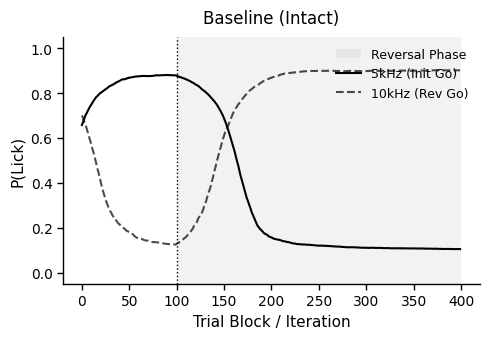

Saved: /content/drive/MyDrive/figs_reversal_v2/Fig_1_Baseline.pdf


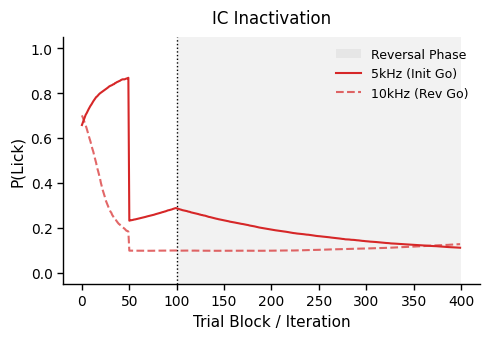

Saved: /content/drive/MyDrive/figs_reversal_v2/Fig_2_IC_Inact.pdf


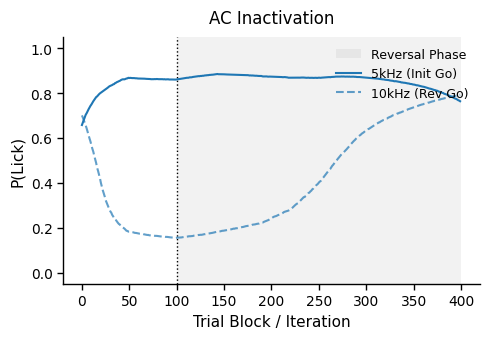

Saved: /content/drive/MyDrive/figs_reversal_v2/Fig_3_AC_Inact.pdf


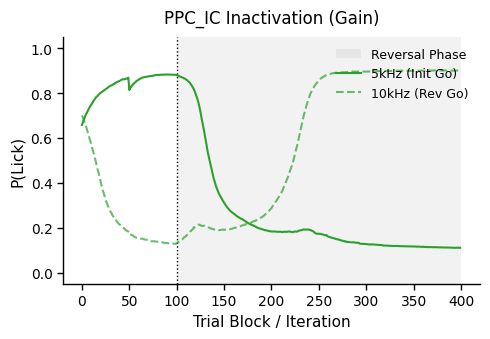

Saved: /content/drive/MyDrive/figs_reversal_v2/Fig_4_PPC_IC_Inact.pdf


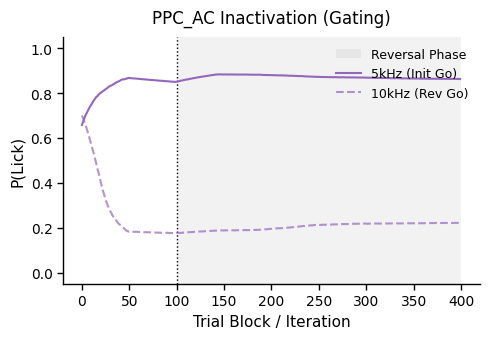

Saved: /content/drive/MyDrive/figs_reversal_v2/Fig_5_PPC_AC_Inact.pdf
>>> Generating Summary Panel...


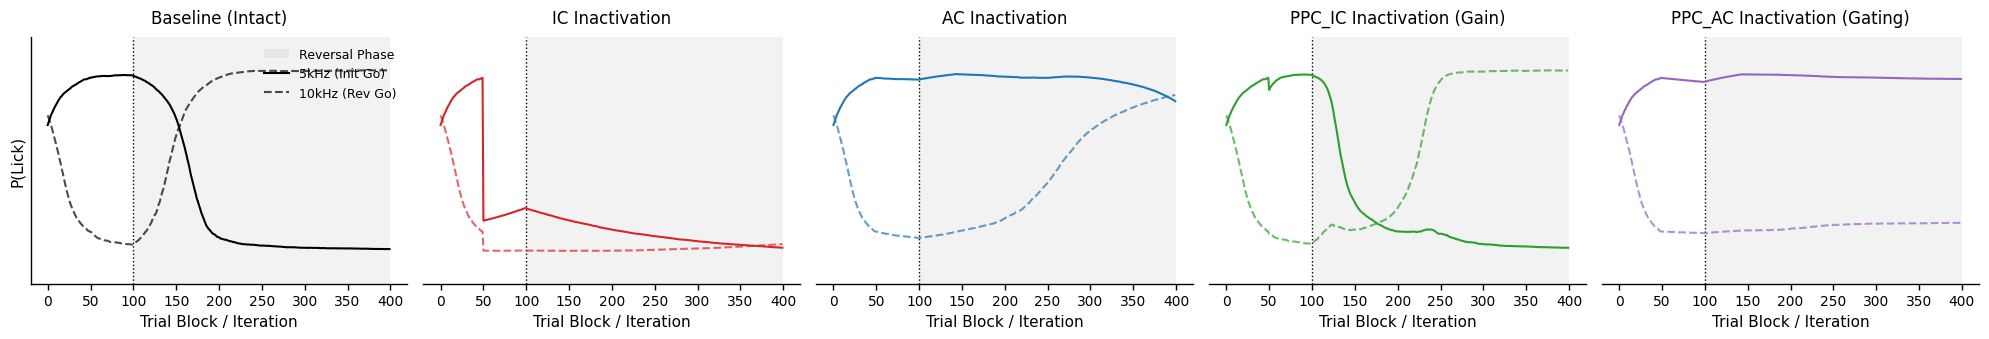

Saved: /content/drive/MyDrive/figs_reversal_v2/Fig_Summary_Panel.pdf
[INFO] Visualization Complete.


In [ ]:
# =========================================
# Cell 2: Visualization & Figure Saving
# =========================================
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. Publication-Ready Plot Settings ---
# Font settings for Nature/Science style (Arial/Helvetica)
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 9

# --- 2. Directory Setup ---
if SAVE_FLAG and os.path.exists('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')
    SAVE_DIR = "/content/drive/MyDrive/figs_reversal_v2"
    os.makedirs(SAVE_DIR, exist_ok=True)
else:
    SAVE_DIR = Path('figs')
    SAVE_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Figures will be saved to local directory: {SAVE_DIR}")

def save_fig(fig, fname):
    """Saves figure in PDF format with tight bounding box."""
    if not fname.lower().endswith(".pdf"):
        fname += ".pdf"
    save_path = os.path.join(SAVE_DIR, fname)
    fig.savefig(save_path, format="pdf", bbox_inches="tight", transparent=True)
    print(f"Saved: {save_path}")
    plt.close(fig)

# --- 3. Plotting Helper Function ---
def plot_performance_trace(ax, logs, title, color_main='k', show_legend=True):
    """
    Generates a standardized performance trace plot.
    """
    it = np.arange(len(logs["plick5"]))

    # Draw Reversal Phase Shading (Gray background for Rule 2)
    ax.axvspan(SWITCH_ITER, len(it), color='gray', alpha=0.1, lw=0, label='Reversal Phase')
    ax.axvline(SWITCH_ITER, color='k', linestyle=':', linewidth=1.0)

    # Plot Traces
    # Solid line: 5kHz (Rule 1 Go), Dashed line: 10kHz (Rule 2 Go)
    ax.plot(it, logs["plick5"], color=color_main, linestyle='-', linewidth=1.5, label="5kHz (Init Go)")
    ax.plot(it, logs["plick10"], color=color_main, linestyle='--', linewidth=1.5, alpha=0.7, label="10kHz (Rev Go)")

    # Formatting
    ax.set_title(title, fontsize=12, pad=10)
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("P(Lick)")
    ax.set_xlabel("Trial Block / Iteration")

    # Despine (Remove top and right borders for cleaner look)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Ticks outward
    ax.tick_params(direction='out', length=4)

    if show_legend:
        ax.legend(frameon=False, loc='upper right')

# --- 4. Generate Individual Figures ---
# List of conditions: (Data, Title, Filename, Color)
conditions = [
    (logs_b,     "Baseline (Intact)",            "Fig_1_Baseline",      'black'),
    (logs_ic,    "IC Inactivation",              "Fig_2_IC_Inact",      'tab:red'),
    (logs_ac,    "AC Inactivation",              "Fig_3_AC_Inact",      'tab:blue'),
    (logs_ppcic, "PPC_IC Inactivation (Gain)",   "Fig_4_PPC_IC_Inact",  'tab:green'),
    (logs_ppcac, "PPC_AC Inactivation (Gating)", "Fig_5_PPC_AC_Inact",  'tab:purple'),
]

print(">>> Generating Individual Figures...")
for logs, title, fname, color in conditions:
    fig, ax = plt.subplots(figsize=(5, 3.5))
    plot_performance_trace(ax, logs, title, color_main=color, show_legend=True)
    plt.tight_layout()
    plt.show()
    save_fig(fig, fname)

# --- 5. Generate Summary Panel (Composite Figure) ---
print(">>> Generating Summary Panel...")
fig_sum, axes = plt.subplots(1, 5, figsize=(20, 3.5), sharey=True)

for i, (logs, title, _, color) in enumerate(conditions):
    ax = axes[i]
    plot_performance_trace(ax, logs, title, color_main=color, show_legend=(i==0))
    if i > 0:
        ax.set_ylabel("") # Only show ylabel on the first plot
        ax.spines['left'].set_visible(False) # Optional: remove y-axis for inner plots
        ax.set_yticks([])

plt.tight_layout()
plt.show()
save_fig(fig_sum, "Fig_Summary_Panel")

print("[INFO] Visualization Complete.")

In [ ]:
# =========================================
# Cell 3: Data Collection & Analysis Metrics
# =========================================
import numpy as np
import torch

# --- 1. Analysis Metrics ---

def calculate_ema(prev, x, beta=0.95):
    """Computes Exponential Moving Average."""
    return beta * prev + (1 - beta) * x

def get_final_performance(reward_trace, tail_window=200):
    """
    Calculates the average reward over the last 'tail_window' trials.
    Used to quantify asymptotic performance.
    """
    tail = min(tail_window, len(reward_trace))
    if tail == 0: return 0.0
    return float(np.mean(reward_trace[-tail:]))

def get_convergence_time(reward_trace, threshold=0.2, ema_beta=0.95):
    """
    Determines the iteration (t80) when performance first crosses a threshold.
    Returns NaN if the threshold is never reached.
    """
    ema = 0.0
    for t, r in enumerate(reward_trace):
        ema = calculate_ema(ema, r, beta=ema_beta)
        if ema >= threshold:
            return t
    return np.nan

# --- 2. Unified Simulation Runner ---

def run_comparative_session(ppc_class, total_iters, switch_iter, sigma=0.15, seed=0):
    """
    Runs a single simulation session for either ParallelPPC or WholePPC.

    Args:
        ppc_class: Class reference (ParallelPPC or WholePPC)
        total_iters: Total number of iterations
        switch_iter: Iteration step where rule reversal occurs
        sigma: Standard deviation of auditory stimuli (noise level)
        seed: Random seed for reproducibility

    Returns:
        logs: Dictionary containing reward, phase, and lick probabilities
    """
    # Set seed
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Update Config locally for this session
    original_sigma = SimConfig.STIM_SIGMA
    SimConfig.STIM_SIGMA = sigma

    # Initialize Network & PPC
    model = FlexStableMLP().to(device)
    ppc = ppc_class() # Instantiate the specific PPC controller

    # Save initial weights (Anchor)
    anchor_weights = clone_state_dict(model)

    # Logging setup
    logs = {
        "reward": [],
        "phase": [],
        "plick5": [],
        "plick10": [],
        "ic_gain": [],
        "ac_flex": []
    }
    r_ema = 0.0

    for t in range(total_iters):
        # Determine Rule Phase
        phase = 1 if t < switch_iter else 2

        # Generate Data
        X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
        X, y = X.to(device), y.to(device)

        # --- Step 1: Probe Forward (Baseline for PPC) ---
        # Run forward pass with default parameters to assess current state
        with torch.no_grad():
            logits, _, _, _ = model(X, scale_ic=0.8, scale_ac=1.0)
            action = torch.distributions.Categorical(logits=logits).sample()

            # Calculate Outcome Counts
            go_target = 0 if phase == 1 else 1
            hit  = ((y==go_target) & (action==0)).sum().item()
            miss = ((y==go_target) & (action==1)).sum().item()
            fa   = ((y!=go_target) & (action==0)).sum().item()
            cr   = ((y!=go_target) & (action==1)).sum().item()

            # Update PPC & Get Modulation Signals
            # Note: Both ParallelPPC and WholePPC return (ic_gain, ac_flex, ...) in the same order
            ic_gain, ac_flex, _, _ = ppc.update(0.0, [hit, miss, fa, cr], current_rule=phase)

        # --- Step 2: Active Forward (Modulated) ---
        # Run forward pass AGAIN with PPC-modulated gain/flexibility
        logits, _, _, _ = model(X, scale_ic=ic_gain, scale_ac=1.0)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()

        # Calculate Reward
        r = torch.zeros_like(y, dtype=torch.float)
        r[:] = 0.0 # Neutral
        r[(y==go_target) & (action==0)] = SimConfig.REWARD_GO
        r[(y!=go_target) & (action==0)] = SimConfig.PENALTY_FA

        mean_r = r.mean().item()

        # Loss Calculation & Backprop
        # Policy Gradient Loss: - (r - baseline) * log_prob - entropy_bonus
        log_prob = dist.log_prob(action)
        entropy = dist.entropy().mean()
        loss = -((r - r_ema) * log_prob).mean() - SimConfig.ENTROPY_BETA * entropy

        model.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

        # Meta-Update (Synaptic Weight Update)
        # Apply flexibility calculated by PPC
        flex_map = build_flexibility_map(model, icro_flex=ac_flex, icac_flex=0.9)
        meta_update(model, anchor_weights, flex_map)

        # Update Reward Baseline (EMA)
        r_ema = calculate_ema(r_ema, mean_r, beta=SimConfig.EMA_BETA)

        # --- Step 3: Logging ---
        logs["reward"].append(mean_r)
        logs["phase"].append(phase)
        logs["ic_gain"].append(ic_gain)
        logs["ac_flex"].append(ac_flex)

        # Log P(Lick) for each tone
        with torch.no_grad():
            # 5kHz (Rule 1 Go)
            mask5 = (y == 0)
            if mask5.any():
                plick5 = (action[mask5] == 0).float().mean().item()
            else:
                plick5 = float('nan')

            # 10kHz (Rule 2 Go)
            mask10 = (y == 1)
            if mask10.any():
                plick10 = (action[mask10] == 0).float().mean().item()
            else:
                plick10 = float('nan')

            logs["plick5"].append(plick5)
            logs["plick10"].append(plick10)

    # Restore global config
    SimConfig.STIM_SIGMA = original_sigma
    return logs

# Wrapper functions for backward compatibility (optional but helpful)
def train_parallel_collect(total_iters, switch_iter, seed=0, sigma=0.15):
    return run_comparative_session(ParallelPPC, total_iters, switch_iter, sigma, seed)

def train_whole_collect(total_iters, switch_iter, seed=0, sigma=0.15):
    return run_comparative_session(WholePPC, total_iters, switch_iter, sigma, seed)

print("[INFO] Analysis metrics and unified training functions are ready.")

[INFO] Analysis metrics and unified training functions are ready.


[INFO] Running Comparison Check (Sigma=0.15, Seed=1767157894)
  > Simulating Parallel PPC...
  > Simulating Whole PPC...
[Result] Saved figure to: /content/drive/MyDrive/figs_reversal_v2/Fig_S2_Model_Comparison_SideBySide.pdf


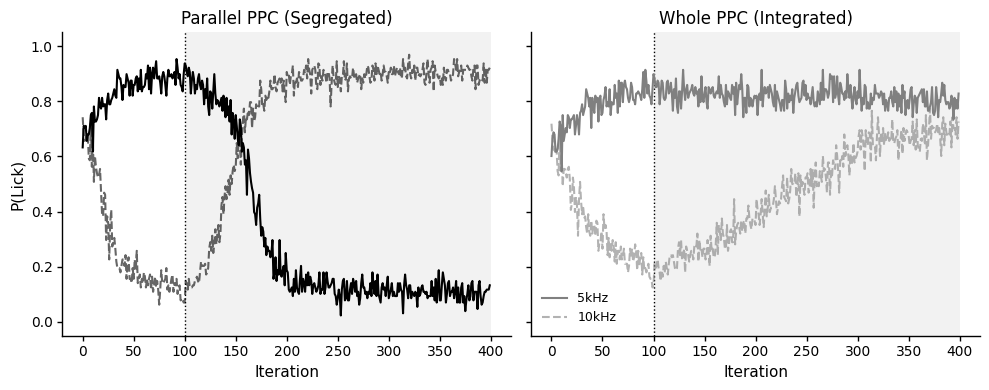


=== Performance Metrics Comparison ===
          Final_Reward  Reversal_Speed (t80)
Parallel      0.390508                  93.0
Whole        -0.114004                   NaN


In [ ]:
# =========================================
# Cell 4: Comparative Verification (Parallel vs Whole)
# =========================================
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Metric Helper Functions (Re-defined for safety) ---
def compute_end_perf(reward_trace, tail=200):
    """Calculates average reward over the last 'tail' trials."""
    tail = min(tail, len(reward_trace))
    if tail == 0: return 0.0
    return float(np.mean(reward_trace[-tail:]))

def compute_t80(reward_trace, ema_beta=0.95, thresh=0.2):
    """
    Finds the first iteration where EMA reward crosses the threshold.
    Returns np.nan if not reached.
    """
    ema = 0.0
    for t, r in enumerate(reward_trace):
        ema = ema_beta * ema + (1 - ema_beta) * r
        if ema >= thresh:
            return t
    return np.nan

# --- 2. Simulation Setup ---
# Verification용 파라미터 (논문 Main Sim과 독립적으로 빠르게 확인)
VERIFY_ITERS  = 400
VERIFY_SWITCH = 100
VERIFY_SIGMA  = SimConfig.STIM_SIGMA  # 0.15 (Default)
VERIFY_SEED   = SEED                  # Same seed for fair comparison

print(f"[INFO] Running Comparison Check (Sigma={VERIFY_SIGMA}, Seed={VERIFY_SEED})")

# --- 3. Run Simulations ---
# (A) Parallel PPC
print("  > Simulating Parallel PPC...")
logs_parallel = train_parallel_collect(
    total_iters=VERIFY_ITERS,
    switch_iter=VERIFY_SWITCH,
    seed=VERIFY_SEED,
    sigma=VERIFY_SIGMA
)

# (B) Whole PPC
print("  > Simulating Whole PPC...")
logs_whole = train_whole_collect(
    total_iters=VERIFY_ITERS,
    switch_iter=VERIFY_SWITCH,
    seed=VERIFY_SEED,
    sigma=VERIFY_SIGMA
)

# --- 4. Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Helper for plotting
def plot_trace_local(ax, logs, title, color):
    it = np.arange(len(logs["plick5"]))
    ax.axvspan(VERIFY_SWITCH, len(it), color='gray', alpha=0.1, lw=0)
    ax.axvline(VERIFY_SWITCH, color='k', linestyle=':', linewidth=1.0)
    ax.plot(it, logs["plick5"], color=color, ls='-', label="5kHz")
    ax.plot(it, logs["plick10"], color=color, ls='--', alpha=0.6, label="10kHz")
    ax.set_title(title)
    ax.set_xlabel("Iteration")
    ax.set_ylim(-0.05, 1.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title.startswith("Whole"): ax.legend(frameon=False)

# Plotting
plot_trace_local(axes[0], logs_parallel, "Parallel PPC (Segregated)", 'black')
axes[0].set_ylabel("P(Lick)")
plot_trace_local(axes[1], logs_whole, "Whole PPC (Integrated)", 'gray')

plt.tight_layout()

# Save & Show
fname = "Fig_S2_Model_Comparison_SideBySide.pdf"
save_path = os.path.join(SAVE_DIR, fname)
fig.savefig(save_path, format="pdf", bbox_inches="tight", transparent=True)
print(f"[Result] Saved figure to: {save_path}")
plt.show()

# --- 5. Quantitative Summary ---
def get_stats(logs):
    # Rule 2 구간(Switch 이후)만 잘라서 분석
    r2_trace = logs['reward'][VERIFY_SWITCH:]
    return {
        "Final_Reward": compute_end_perf(logs['reward']),
        "Reversal_Speed (t80)": compute_t80(r2_trace, thresh=0.2)
    }

stats_df = pd.DataFrame({
    "Parallel": get_stats(logs_parallel),
    "Whole": get_stats(logs_whole)
})

print("\n=== Performance Metrics Comparison ===")
print(stats_df.T)

In [ ]:
# =========================================
# Cell 5: (Optional) Advanced Training Utilities (Checkpointing)
# =========================================
# Note: This cell provides functions to save/load model states between phases.
# Useful for running multiple Reversal conditions from a shared Pre-trained Rule 1 state.

def save_wppc_state(wppc):
    """Saves the dynamic state (EMA traces) of the WholePPC module."""
    state = {}
    if hasattr(wppc, "goal_ema"):
        state["goal_ema"] = float(wppc.goal_ema)
    return state

def load_wppc_state(wppc, state: dict):
    """Restores the dynamic state of the WholePPC module."""
    if not state: return
    if "goal_ema" in state and hasattr(wppc, "goal_ema"):
        wppc.goal_ema = float(state["goal_ema"])

def pretrain_whole_rule1(pre_iters, sigma=0.15, seed=0):
    """
    Trains Whole-PPC model on Rule 1 only and returns a checkpoint.
    """
    # Config setup
    original_sigma = SimConfig.STIM_SIGMA
    SimConfig.STIM_SIGMA = sigma

    torch.manual_seed(seed)
    model = FlexStableMLP().to(device)
    wppc  = WholePPC()
    init  = clone_state_dict(model)

    logs = {"reward": [], "plick5": [], "plick10": []}
    r_ema = 0.0

    try:
        for t in range(pre_iters):
            phase = 1 # Force Rule 1
            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)

            # 1. Probe Forward
            with torch.no_grad():
                logits, _, _, _ = model(X, scale_ic=0.8, scale_ac=1.0)
                a = torch.distributions.Categorical(logits=logits).sample()

                # Metrics
                go_target = 0
                hit  = ((y==go_target)&(a==0)).sum().item()
                miss = ((y==go_target)&(a==1)).sum().item()
                fa   = ((y!=go_target)&(a==0)).sum().item()
                cr   = ((y!=go_target)&(a==1)).sum().item()

                ic_gain, icro_flex, _, _ = wppc.update(0.0, [hit, miss, fa, cr], current_rule=phase)

            # 2. Active Forward
            logits2, _, _, _ = model(X, scale_ic=ic_gain, scale_ac=1.0)
            dist2 = torch.distributions.Categorical(logits=logits2)
            a2 = dist2.sample()

            r2 = torch.zeros_like(y, dtype=torch.float)
            r2[(y==go_target)&(a2==0)] = SimConfig.REWARD_GO
            r2[(y!=go_target)&(a2==0)] = SimConfig.PENALTY_FA
            mean_r = r2.mean().item()

            loss = -((r2 - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

            flex_now = build_flexibility_map(model, icro_flex=icro_flex, icac_flex=0.9)
            meta_update(model, init, flex_now)

            r_ema = calculate_ema(r_ema, mean_r, beta=SimConfig.EMA_BETA)

            # Logging
            logs["reward"].append(mean_r)
            with torch.no_grad():
                m5 = (y==0)
                p5 = (a2[m5]==0).float().mean().item() if m5.any() else float('nan')
                m10 = (y==1)
                p10 = (a2[m10]==0).float().mean().item() if m10.any() else float('nan')
                logs["plick5"].append(p5)
                logs["plick10"].append(p10)

        # Create Checkpoint
        checkpoint = {
            "model_state": clone_state_dict(model),
            "wppc_state":  save_wppc_state(wppc),
            "anchor_state": init # Need to save anchor for continuity
        }

    finally:
        SimConfig.STIM_SIGMA = original_sigma

    return logs, checkpoint

def reversal_only_whole(rev_iters, checkpoint, sigma=0.15, seed=0):
    """
    Trains Whole-PPC model on Rule 2 only, starting from a checkpoint.
    """
    original_sigma = SimConfig.STIM_SIGMA
    SimConfig.STIM_SIGMA = sigma

    torch.manual_seed(seed)
    model = FlexStableMLP().to(device)
    wppc  = WholePPC()

    # Load Checkpoint
    if checkpoint is not None:
        model.load_state_dict(checkpoint["model_state"])
        load_wppc_state(wppc, checkpoint["wppc_state"])
        init = checkpoint["anchor_state"] # Restore anchor
    else:
        init = clone_state_dict(model) # Should not happen usually

    logs = {"reward": [], "plick5": [], "plick10": []}
    r_ema = 0.0 # Reset reward baseline for new phase or keep? Usually reset is safer for stability

    try:
        for t in range(rev_iters):
            phase = 2 # Force Rule 2
            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)

            # 1. Probe
            with torch.no_grad():
                logits, _, _, _ = model(X, scale_ic=0.8, scale_ac=1.0)
                a = torch.distributions.Categorical(logits=logits).sample()

                go_target = 1 # Rule 2 Go
                hit  = ((y==go_target)&(a==0)).sum().item()
                miss = ((y==go_target)&(a==1)).sum().item()
                fa   = ((y!=go_target)&(a==0)).sum().item()
                cr   = ((y!=go_target)&(a==1)).sum().item()

                ic_gain, icro_flex, _, _ = wppc.update(0.0, [hit, miss, fa, cr], current_rule=phase)

            # 2. Active
            logits2, _, _, _ = model(X, scale_ic=ic_gain, scale_ac=1.0)
            dist2 = torch.distributions.Categorical(logits=logits2)
            a2 = dist2.sample()

            r2 = torch.zeros_like(y, dtype=torch.float)
            r2[(y==go_target)&(a2==0)] = SimConfig.REWARD_GO
            r2[(y!=go_target)&(a2==0)] = SimConfig.PENALTY_FA
            mean_r = r2.mean().item()

            loss = -((r2 - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

            flex_now = build_flexibility_map(model, icro_flex=icro_flex, icac_flex=0.9)
            meta_update(model, init, flex_now)

            r_ema = calculate_ema(r_ema, mean_r, beta=SimConfig.EMA_BETA)

            logs["reward"].append(mean_r)
            with torch.no_grad():
                m5 = (y==0)
                p5 = (a2[m5]==0).float().mean().item() if m5.any() else float('nan')
                m10 = (y==1)
                p10 = (a2[m10]==0).float().mean().item() if m10.any() else float('nan')
                logs["plick5"].append(p5)
                logs["plick10"].append(p10)

    finally:
        SimConfig.STIM_SIGMA = original_sigma

    return logs

In [ ]:
# =========================================
# Cell 5: Rule 1 Training to Performance Threshold
# =========================================

def _core_train_rule1(ppc_class, thresh, max_iters, sigma, seed):
    """
    Internal helper function to avoid code duplication.
    """
    # 1. Config & Setup
    original_sigma = SimConfig.STIM_SIGMA
    SimConfig.STIM_SIGMA = sigma

    torch.manual_seed(seed)
    np.random.seed(seed)

    model = FlexStableMLP().to(device)
    ppc   = ppc_class()
    init  = clone_state_dict(model)

    logs = {"reward": [], "plick5": [], "plick10": []}
    r_ema = 0.0
    t_hit = None

    try:
        for t in range(max_iters):
            phase = 1 # Rule 1 Only

            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)

            # 1st Forward (Probe)
            with torch.no_grad():
                logits, _, _, _ = model(X, scale_ic=0.8, scale_ac=1.0)
                a = torch.distributions.Categorical(logits=logits).sample()
                lick_rate = (a == 0).float().mean().item()

                # Rule 1: Tone 0 is GO
                go_target = 0
                hit  = ((y==go_target)&(a==0)).sum().item()
                miss = ((y==go_target)&(a==1)).sum().item()
                fa   = ((y!=go_target)&(a==0)).sum().item()
                cr   = ((y!=go_target)&(a==1)).sum().item()

                # PPC Update
                ic_gain, ac_flex, _, _ = ppc.update(lick_rate, [hit, miss, fa, cr], current_rule=phase)

            # 2nd Forward (Active)
            logits2, _, _, _ = model(X, scale_ic=ic_gain, scale_ac=1.0)
            dist2 = torch.distributions.Categorical(logits=logits2)
            a2 = dist2.sample()

            r2 = torch.zeros_like(y, dtype=torch.float)
            r2[(y==go_target)&(a2==0)] = SimConfig.REWARD_GO
            r2[(y!=go_target)&(a2==0)] = SimConfig.PENALTY_FA
            mean_r = r2.mean().item()

            loss = -((r2 - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

            flex_now = build_flexibility_map(model, icro_flex=ac_flex, icac_flex=0.9)
            meta_update(model, init, flex_now)

            r_ema = calculate_ema(r_ema, mean_r, beta=SimConfig.EMA_BETA)

            # Logging
            logs["reward"].append(mean_r)
            with torch.no_grad():
                m5 = (y==0); m10 = (y==1)
                p5 = (a2[m5]==0).float().mean().item() if m5.any() else float('nan')
                p10 = (a2[m10]==0).float().mean().item() if m10.any() else float('nan')
                logs["plick5"].append(p5)
                logs["plick10"].append(p10)

            # Check Threshold
            if (t_hit is None) and (r_ema >= thresh):
                t_hit = t
                break # Stop training upon reaching threshold

    finally:
        SimConfig.STIM_SIGMA = original_sigma

    if t_hit is None:
        print(f"[Warning] {ppc_class.__name__}: Never reached threshold {thresh} within {max_iters} steps.")
        t_hit = max_iters - 1

    final_state = clone_state_dict(model)
    return final_state, logs, t_hit


# --- User-Facing Functions (Signatures Preserved) ---

def train_parallel_rule1_to_threshold(thresh=0.2, max_iters=1000, sigma=0.15, seed=0):
    """
    Trains Parallel PPC model on Rule 1 until reward EMA >= thresh.
    Returns: (state_dict, logs, t_hit)
    """
    return _core_train_rule1(ParallelPPC, thresh, max_iters, sigma, seed)

def train_whole_rule1_to_threshold(thresh=0.2, max_iters=1000, sigma=0.15, seed=0):
    """
    Trains Whole PPC model on Rule 1 until reward EMA >= thresh.
    Returns: (state_dict, logs, t_hit)
    """
    return _core_train_rule1(WholePPC, thresh, max_iters, sigma, seed)

In [ ]:
# =========================================
# Cell 6: Reversal Phase from Checkpoint
# =========================================

def _core_reversal_phase(ppc_class, state_dict, iters_reversal, sigma, seed):
    """
    Internal helper for running the reversal phase.
    """
    # 1. Config
    original_sigma = SimConfig.STIM_SIGMA
    SimConfig.STIM_SIGMA = sigma

    torch.manual_seed(seed)
    np.random.seed(seed)

    # 2. Restore Model State
    model = FlexStableMLP().to(device)
    model.load_state_dict(state_dict)

    # Initialize NEW PPC controller for the new phase
    ppc = ppc_class()

    # Anchor is reset to the trained model (Transfer Learning setup)
    init = clone_state_dict(model)

    logs = {"reward": [], "plick5": [], "plick10": []}
    r_ema = 0.0

    try:
        for t in range(iters_reversal):
            phase = 2 # Rule 2 Only

            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)

            # 1st Forward
            with torch.no_grad():
                logits, _, _, _ = model(X, scale_ic=0.8, scale_ac=1.0)
                a = torch.distributions.Categorical(logits=logits).sample()
                lick_rate = (a == 0).float().mean().item()

                # Rule 2: Tone 1 is GO
                go_target = 1
                hit  = ((y==go_target)&(a==0)).sum().item()
                miss = ((y==go_target)&(a==1)).sum().item()
                fa   = ((y!=go_target)&(a==0)).sum().item()
                cr   = ((y!=go_target)&(a==1)).sum().item()

                ic_gain, ac_flex, _, _ = ppc.update(lick_rate, [hit, miss, fa, cr], current_rule=phase)

            # 2nd Forward
            logits2, _, _, _ = model(X, scale_ic=ic_gain, scale_ac=1.0)
            dist2 = torch.distributions.Categorical(logits=logits2)
            a2 = dist2.sample()

            r2 = torch.zeros_like(y, dtype=torch.float)
            r2[(y==go_target)&(a2==0)] = SimConfig.REWARD_GO
            r2[(y!=go_target)&(a2==0)] = SimConfig.PENALTY_FA
            mean_r = r2.mean().item()

            loss = -((r2 - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

            flex_now = build_flexibility_map(model, icro_flex=ac_flex, icac_flex=0.9)
            meta_update(model, init, flex_now)

            r_ema = calculate_ema(r_ema, mean_r, beta=SimConfig.EMA_BETA)

            # Logging
            logs["reward"].append(mean_r)
            with torch.no_grad():
                m5 = (y==0); m10 = (y==1)
                p5 = (a2[m5]==0).float().mean().item() if m5.any() else float('nan')
                p10 = (a2[m10]==0).float().mean().item() if m10.any() else float('nan')
                logs["plick5"].append(p5)
                logs["plick10"].append(p10)

    finally:
        SimConfig.STIM_SIGMA = original_sigma

    return logs


# --- User-Facing Functions (Signatures Preserved) ---

def run_reversal_only_parallel_from_checkpoint(state_dict, iters_reversal=400, sigma=0.15, seed=1):
    """
    Continues training Parallel PPC on Rule 2 from a Rule 1 checkpoint.
    """
    return _core_reversal_phase(ParallelPPC, state_dict, iters_reversal, sigma, seed)


def run_reversal_only_whole_from_checkpoint(state_dict, iters_reversal=400, sigma=0.15, seed=1):
    """
    Continues training Whole PPC on Rule 2 from a Rule 1 checkpoint.
    """
    return _core_reversal_phase(WholePPC, state_dict, iters_reversal, sigma, seed)

In [ ]:
# =========================================
# Cell 7: Matplotlib Configuration for Publication
# =========================================
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- Illustrator/PDF Export Settings ---
# Note: Type 42 (TrueType) ensures text is editable in Illustrator.
plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 10,
    "axes.labelsize": 9,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],

    # Export settings
    "svg.fonttype": "none",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,

    # Visual cleanliness
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.0,
})

print("[INFO] Matplotlib style updated for publication.")

[INFO] Matplotlib style updated for publication.


[INFO] Running Threshold Analysis (Thresh=0.2, Sigma=0.15)...
  > Simulating Whole PPC...
  > Simulating Parallel PPC...


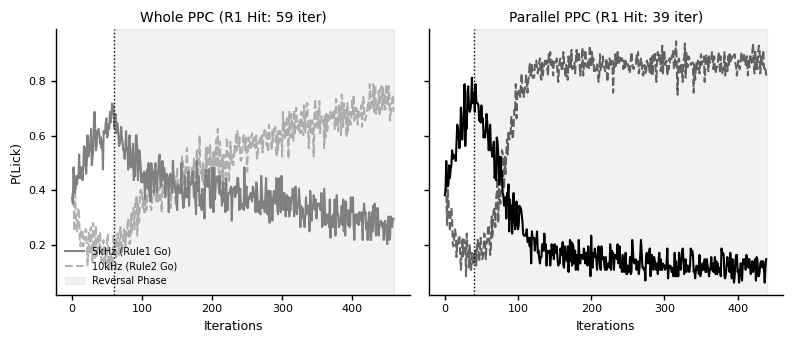


=== Threshold Results ===
Whole PPC    - Rule 1 Time: 59 iters
Parallel PPC - Rule 1 Time: 39 iters


In [ ]:
# =========================================
# Cell 8: Threshold-based Learning Comparison
# =========================================
# This experiment compares how fast Parallel vs Whole architectures
# acquire Rule 1 and adapt to Rule 2 (Reversal).

# 1. Experiment Parameters
SIGMA_THRESH = 0.15
SEED_THRESH  = 0
THRESH_VAL   = 0.2
REV_ITERS    = 400
MAX_ITERS    = 1000

print(f"[INFO] Running Threshold Analysis (Thresh={THRESH_VAL}, Sigma={SIGMA_THRESH})...")

# 2. Run Whole PPC
print("  > Simulating Whole PPC...")
whole_ckpt, whole_logs_r1, whole_t_hit = train_whole_rule1_to_threshold(
    thresh=THRESH_VAL, max_iters=MAX_ITERS, sigma=SIGMA_THRESH, seed=SEED_THRESH
)
whole_logs_r2 = run_reversal_only_whole_from_checkpoint(
    whole_ckpt, iters_reversal=REV_ITERS, sigma=SIGMA_THRESH, seed=SEED_THRESH
)

# 3. Run Parallel PPC
print("  > Simulating Parallel PPC...")
par_ckpt, par_logs_r1, par_t_hit = train_parallel_rule1_to_threshold(
    thresh=THRESH_VAL, max_iters=MAX_ITERS, sigma=SIGMA_THRESH, seed=SEED_THRESH
)
par_logs_r2 = run_reversal_only_parallel_from_checkpoint(
    par_ckpt, iters_reversal=REV_ITERS, sigma=SIGMA_THRESH, seed=SEED_THRESH
)

# 4. Visualization (Combined Traces)
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

def plot_joined_logs(ax, logs1, logs2, title, color):
    # Combine Rule 1 and Rule 2 traces
    p5 = logs1["plick5"] + logs2["plick5"]
    p10 = logs1["plick10"] + logs2["plick10"]
    it = np.arange(len(p5))
    switch_pt = len(logs1["plick5"])

    # Plot
    ax.plot(it, p5, color=color, ls='-', label='5kHz (Rule1 Go)')
    ax.plot(it, p10, color=color, ls='--', alpha=0.6, label='10kHz (Rule2 Go)')

    # Markers
    ax.axvline(switch_pt, color='k', ls=':', lw=1)
    ax.axvspan(switch_pt, len(it), color='gray', alpha=0.1, label='Reversal Phase')
    ax.set_title(title)
    ax.set_xlabel("Iterations")

# Plot Whole
plot_joined_logs(axes[0], whole_logs_r1, whole_logs_r2,
                 f"Whole PPC (R1 Hit: {whole_t_hit} iter)", 'gray')
axes[0].set_ylabel("P(Lick)")
axes[0].legend(frameon=False, loc='lower left', fontsize=7)

# Plot Parallel
plot_joined_logs(axes[1], par_logs_r1, par_logs_r2,
                 f"Parallel PPC (R1 Hit: {par_t_hit} iter)", 'black')

plt.tight_layout()
plt.show()

# Print Comparison
print("\n=== Threshold Results ===")
print(f"Whole PPC    - Rule 1 Time: {whole_t_hit} iters")
print(f"Parallel PPC - Rule 1 Time: {par_t_hit} iters")

In [ ]:
# =========================================
# Cell 9: Configuration for Main Batch Simulation
# =========================================
import os
import numpy as np
from pathlib import Path

# 1. Session Structure (Manuscript requirement)
INIT_ITERS   = 50
PHASE1_ADDIT = 50
PHASE2_ITERS = 300

PHASE1_ITERS = INIT_ITERS + PHASE1_ADDIT  # Rule 1 Total (100)
TOTAL_ITERS  = PHASE1_ITERS + PHASE2_ITERS # Total (400)
SWITCH       = PHASE1_ITERS               # Rule 2 starts at 100

# 2. Simulation Parameters
SIGMA_RUN = 0.50          # Noise level for main analysis
SEEDS     = list(range(20)) # Number of independent runs (N=20)
TAIL_R2   = 100            # Window for calculating final performance

# 3. Directory Setup
if SAVE_FLAG and os.path.exists('/content/drive'):
    from google.colab import drive
    # drive.mount('/content/drive') # Uncomment if not mounted
    SAVE_DIR = "/content/drive/MyDrive/figs_v3_parallel_inactivation_only"
    os.makedirs(SAVE_DIR, exist_ok=True)
else:
    SAVE_DIR = Path('figs_v3_parallel_inactivation_only')
    SAVE_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Figures will be saved to local directory: {SAVE_DIR}")

# 4. Condition Specifications
def ev(start, end, scale):
    """Event helper: creates a list of event dictionaries."""
    return [{"start": int(start), "end": int(end), "scale": float(scale)}]

# Defines the 5 key conditions for the paper
# Note: Inactivation applied from SWITCH (Rule 2 onset) to end of task.
COND_SPECS = [
    # 1. Baseline
    dict(name="control",      ic_events=None,                 ac_events=None,                 ppcic_events=None,                 ppcac_events=None),

    # 2. AC Inactivation (AC off during Reversal)
    dict(name="ac_inact",     ic_events=None,                 ac_events=ev(INIT_ITERS, TOTAL_ITERS, 0.0), ppcic_events=None,                 ppcac_events=None),

    # 3. IC Inactivation (IC gain reduced during Reversal)
    dict(name="ic_inact",     ic_events=ev(INIT_ITERS, TOTAL_ITERS, 0.3), ac_events=None,                 ppcic_events=None,                 ppcac_events=None),

    # 4. PPC_AC Inactivation (Flexibility Gating off)
    dict(name="ppcac_inact",  ic_events=None,                 ac_events=None,                 ppcic_events=None,                 ppcac_events=ev(SWITCH, TOTAL_ITERS, 0.0)),

    # 5. PPC_IC Inactivation (Stability Modulation off)
    dict(name="ppcic_inact",  ic_events=None,                 ac_events=None,                 ppcic_events=ev(SWITCH, TOTAL_ITERS, 0.0), ppcac_events=None),
]

print(f"[INFO] Configured {len(COND_SPECS)} conditions with N={len(SEEDS)} seeds each.")
print(f"[INFO] Noise Level (Sigma): {SIGMA_RUN}")
print(f"[INFO] Inactivation Window: Iter {SWITCH} to {TOTAL_ITERS}")

[INFO] Configured 5 conditions with N=20 seeds each.
[INFO] Noise Level (Sigma): 0.5
[INFO] Inactivation Window: Iter 100 to 400


In [ ]:
# =========================================
# Cell 10: Main Simulation Runner & Data Aggregation (Fixed)
# =========================================
import numpy as np
import torch

# --- 1. Helper Functions ---

def _active(events, t):
    if not events: return 1.0
    for e in events:
        if e["start"] <= t < e["end"]:
            return float(e.get("scale", 1.0))
    return 1.0

@torch.no_grad()
def _rates_from_batch(y, a, go_label: int):
    # (이전과 동일한 Metric 계산 함수)
    y, a = y.detach(), a.detach()

    # P(Lick)
    plick5 = (a[y==0]==0).float().mean().item() if (y==0).any() else float("nan")
    plick10 = (a[y==1]==0).float().mean().item() if (y==1).any() else float("nan")

    # Hit/FA/Miss/CR
    go_mask, nogo_mask = (y == go_label), (y != go_label)
    n_go, n_nogo = int(go_mask.sum().item()), int(nogo_mask.sum().item())

    hit  = int((go_mask   & (a == 0)).sum().item())
    miss = int((go_mask   & (a == 1)).sum().item())
    fa   = int((nogo_mask & (a == 0)).sum().item())
    cr   = int((nogo_mask & (a == 1)).sum().item())

    eps = 1e-9
    return plick5, plick10, hit/(n_go+eps), miss/(n_go+eps), fa/(n_nogo+eps), cr/(n_nogo+eps)


# --- 2. Main Simulation Runner ---

def train_with_rulebased_ppc_events_collect(
    total_iters: int,
    switch_iter: int,
    seed: int,
    sigma: float,
    ic_events=None, ac_events=None, ppcic_events=None, ppcac_events=None,
):
    # 1. Config
    original_sigma = SimConfig.STIM_SIGMA
    SimConfig.STIM_SIGMA = float(sigma)
    torch.manual_seed(int(seed)); np.random.seed(int(seed))

    model = FlexStableMLP().to(device)
    ppc   = ParallelPPC()
    init  = clone_state_dict(model)

    logs = {
        "phase": [], "reward": [], "plick5": [], "plick10": [],
        "hit": [], "miss": [], "fa": [], "cr": [],
        "ic_gain": [], "ac_flex": [],
    }
    r_ema = 0.0

    try:
        for t in range(total_iters):
            phase = 1 if t < switch_iter else 2
            go_label = 0 if phase == 1 else 1

            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)

            ic_scale    = _active(ic_events, t)
            ac_scale    = _active(ac_events, t)
            ppcic_scale = _active(ppcic_events, t)
            ppcac_scale = _active(ppcac_events, t)

            # --- 1st Forward (Probe) ---
            with torch.no_grad():
                logits, _, _, _ = model(X, scale_ic=0.8 * ic_scale, scale_ac=ac_scale)
                a1 = torch.distributions.Categorical(logits=logits).sample()

                # Update PPC (Get errors)
                hit1  = ((y==go_label)&(a1==0)).sum().item()
                miss1 = ((y==go_label)&(a1==1)).sum().item()
                fa1   = ((y!=go_label)&(a1==0)).sum().item()
                cr1   = ((y!=go_label)&(a1==1)).sum().item()

                # [중요] ic_err를 여기서 받아서 아래 로직에 사용해야 함
                ic_gain, ac_flex, ic_err, ac_err = ppc.update(
                    0.0, [hit1, miss1, fa1, cr1], current_rule=phase
                )

            # --- Modulation Switch Logic (RESTORED ORIGINAL LOGIC) ---

            # 1. IC Gain Control
            if ic_scale == 0.0:
                ic_gain = 0.0
            elif ppcic_scale == 0.0:
                e0 = 0.9     # threshold
                k  = 25.0    # slope
                g_min = 0.5
                # ic_err가 높을수록 suppress가 0에 가까워져서 gain이 g_min으로 떨어짐
                suppress = 1.0 / (1.0 + np.exp(k * (ic_err - e0)))
                ic_gain = g_min + (ic_gain - g_min) * suppress
            else:
                # Normal scale modulation
                ic_gain = 0.8 + (ic_gain - 0.8) * ppcic_scale

            # 2. AC Flexibility Control
            if ac_scale == 0.0:
                icro_flex = 0.08
            elif ppcac_scale == 0.0:
                icro_flex = 0.0003 # PPC_AC Inactivation -> Minimum flexibility
            else:
                icro_flex = ac_flex

            # --- 2nd Forward (Active) ---
            logits2, _, _, _ = model(X, scale_ic=ic_gain * ic_scale, scale_ac=ac_scale)
            dist2 = torch.distributions.Categorical(logits=logits2)
            a2    = dist2.sample()

            r2 = torch.where((y==go_label)&(a2==0), SimConfig.REWARD_GO,
                 torch.where((y!=go_label)&(a2==0), SimConfig.PENALTY_FA, 0.0)).to(device)
            mean_r = float(r2.mean().item())

            loss = -((r2 - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()

            model.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), SimConfig.GRAD_CLIP)

            flex_now = build_flexibility_map(model, icro_flex=icro_flex, icac_flex=0.9)
            meta_update(model, init, flex_now)

            r_ema = SimConfig.EMA_BETA * r_ema + (1.0 - SimConfig.EMA_BETA) * mean_r

            # Logging
            p5, p10, h, m, fa, cr = _rates_from_batch(y, a2, go_label)
            logs["phase"].append(phase); logs["reward"].append(mean_r)
            logs["plick5"].append(p5); logs["plick10"].append(p10)
            logs["hit"].append(h); logs["miss"].append(m); logs["fa"].append(fa); logs["cr"].append(cr)
            logs["ic_gain"].append(float(ic_gain)); logs["ac_flex"].append(float(icro_flex))

    finally:
        SimConfig.STIM_SIGMA = original_sigma

    return logs

# --- 3. Data Aggregation Helpers (Same as before) ---
def _stack(x_list): return np.stack([np.asarray(x, dtype=float) for x in x_list], axis=0)
def mean_sem(mat):
    m = np.nanmean(mat, axis=0)
    s = np.nanstd(mat, axis=0, ddof=1) / np.sqrt(mat.shape[0])
    return m, s
def end_mean_sem_rule2(mat, switch, tail):
    seg = mat[:, switch:]; tail = min(int(tail), seg.shape[1])
    vals = np.nanmean(seg[:, -tail:], axis=1)
    return float(np.nanmean(vals)), float(np.nanstd(vals, ddof=1)/np.sqrt(len(vals))), vals
def end_mean_sem_rule1(mat, switch, tail):
    seg = mat[:, :switch]; tail = min(int(tail), seg.shape[1])
    vals = np.nanmean(seg[:, -tail:], axis=1)
    return float(np.nanmean(vals)), float(np.nanstd(vals, ddof=1)/np.sqrt(len(vals))), vals

print("[INFO] Simulation runner updated.")

[INFO] Simulation runner updated.


In [ ]:
# =========================================
# Cell 11: Execution of Main Simulation Batch
# =========================================
import time

print(f"[INFO] Starting Batch Simulation...")
print(f"       Conditions: {len(COND_SPECS)} {list(c['name'] for c in COND_SPECS)}")
print(f"       Seeds per condition: {len(SEEDS)}")
print(f"       Total Iterations: {TOTAL_ITERS}")
print("-" * 60)

start_time = time.time()

# Store results: cond_name -> dict of stacked arrays (nseed, T)
all_cond = {}

for spec in COND_SPECS:
    cname = spec["name"]
    print(f"[RUNNING] Condition: {cname:<15} ...", end="", flush=True)

    cond_start = time.time()
    logs_list = []

    for sd in SEEDS:
        # Call the simulation engine (defined in Cell 10)
        logs = train_with_rulebased_ppc_events_collect(
            total_iters=TOTAL_ITERS,
            switch_iter=SWITCH,
            seed=sd,
            sigma=SIGMA_RUN,
            ic_events=spec["ic_events"],
            ac_events=spec["ac_events"],
            ppcic_events=spec["ppcic_events"],
            ppcac_events=spec["ppcac_events"],
        )
        logs_list.append(logs)

    # Efficient Stacking
    # Automatically stack all numeric keys tracked in logs
    keys_to_stack = ["plick5", "plick10", "hit", "miss", "fa", "cr", "reward", "ic_gain", "ac_flex"]

    all_cond[cname] = {
        k: _stack([L[k] for L in logs_list]) for k in keys_to_stack
    }

    elapsed = time.time() - cond_start
    print(f" Done ({elapsed:.1f}s)")

total_elapsed = time.time() - start_time
print("-" * 60)
print(f"[DONE] All simulations completed in {total_elapsed:.1f}s.")
print(f"[INFO] Stored Conditions: {list(all_cond.keys())}")

# Sanity Check: Verify Data Dimensions
sample_cond = list(all_cond.keys())[0]
sample_shape = all_cond[sample_cond]["plick5"].shape
print(f"[CHECK] Data Shape (Seeds, Time): {sample_shape}  <-- Should be ({len(SEEDS)}, {TOTAL_ITERS})")

[INFO] Starting Batch Simulation...
       Conditions: 5 ['control', 'ac_inact', 'ic_inact', 'ppcac_inact', 'ppcic_inact']
       Seeds per condition: 20
       Total Iterations: 400
------------------------------------------------------------
[RUNNING] Condition: control         ... Done (65.1s)
[RUNNING] Condition: ac_inact        ... Done (65.2s)
[RUNNING] Condition: ic_inact        ... Done (63.9s)
[RUNNING] Condition: ppcac_inact     ... Done (63.8s)
[RUNNING] Condition: ppcic_inact     ... Done (63.7s)
------------------------------------------------------------
[DONE] All simulations completed in 321.6s.
[INFO] Stored Conditions: ['control', 'ac_inact', 'ic_inact', 'ppcac_inact', 'ppcic_inact']
[CHECK] Data Shape (Seeds, Time): (20, 400)  <-- Should be (20, 400)


[INFO] Generating Learning Curves (Save Dir: /content/drive/MyDrive/figs_v3_parallel_inactivation_only)...
Saved: Curve_control


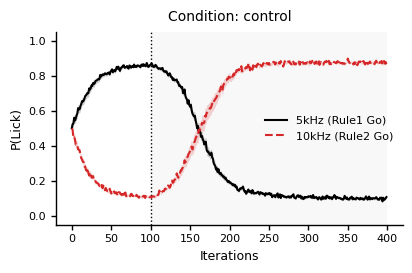

Saved: Curve_ac_inact


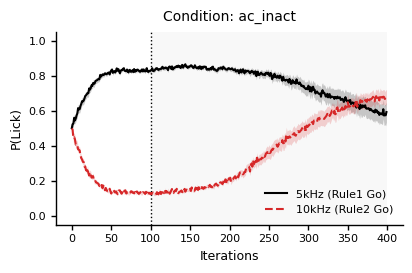

Saved: Curve_ic_inact


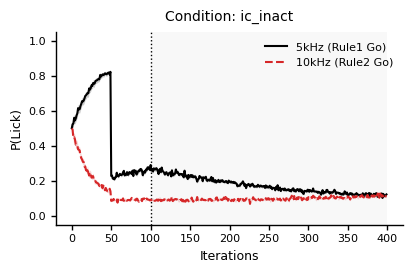

Saved: Curve_ppcac_inact


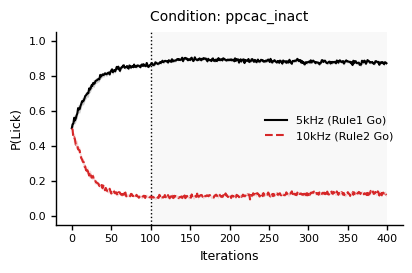

Saved: Curve_ppcic_inact


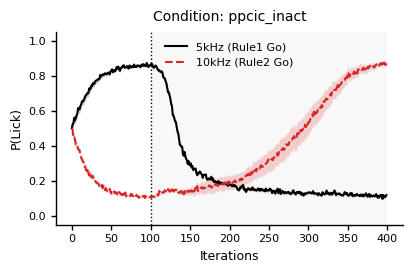

[INFO] Generating Summary Bar Plots...
Saved: Bar_Rule2End_HIT


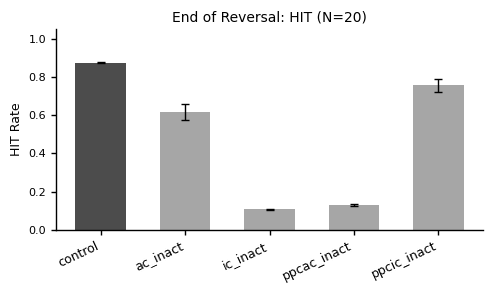

Saved: Bar_Rule2End_MISS


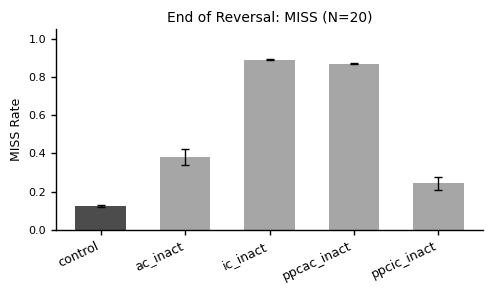

Saved: Bar_Rule2End_FA


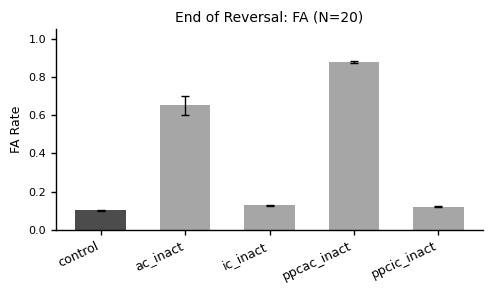

Saved: Bar_Rule2End_CR


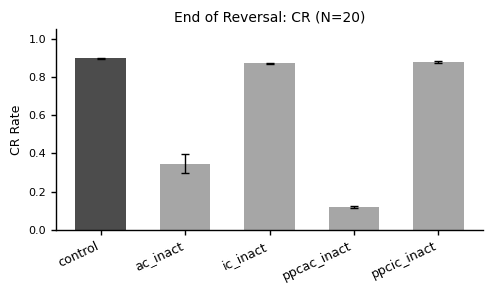

[DONE] All figures saved to: /content/drive/MyDrive/figs_v3_parallel_inactivation_only


In [ ]:
# =========================================
# Cell 12: Visualization of Batch Results (Fixed)
# =========================================
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# [FIX] Ensure SAVE_DIR is a Path object for the '/' operator to work
SAVE_DIR = Path(SAVE_DIR)

# --- 1. Helper Functions for Visualization ---

def save_vec(fig, stem: Path):
    """
    Saves figure in multiple formats (SVG/PDF for editing, PNG for preview).
    """
    # Ensure directory exists (Safety check)
    stem.parent.mkdir(parents=True, exist_ok=True)

    fig.savefig(stem.with_suffix(".svg"), bbox_inches="tight", transparent=True)
    fig.savefig(stem.with_suffix(".pdf"), bbox_inches="tight", transparent=True)
    # PNG for quick preview in Colab
    fig.savefig(stem.with_suffix(".png"), bbox_inches="tight", dpi=150, transparent=False, facecolor='white')
    print(f"Saved: {stem.name}")

def plot_condition_plick(cname, mat5, mat10, switch, outdir: Path):
    """
    Plots p(lick) learning curves for a single condition (Mean ± SEM).
    """
    x = np.arange(mat5.shape[1])

    # Calculate stats using helper from Cell 10
    m5, s5   = mean_sem(mat5)
    m10, s10 = mean_sem(mat10)

    fig, ax = plt.subplots(figsize=(4.2, 2.8))

    # Reversal Phase Shading
    ax.axvspan(switch, len(x), color='gray', alpha=0.05, lw=0)
    ax.axvline(switch, color='k', linestyle=':', linewidth=1.0)

    # Plot 5kHz (Rule 1 Go)
    l1, = ax.plot(x, m5, color='black', linestyle='-', linewidth=1.5, label="5kHz (Rule1 Go)")
    ax.fill_between(x, m5 - s5, m5 + s5, alpha=0.2, color=l1.get_color(), lw=0)

    # Plot 10kHz (Rule 2 Go)
    l2, = ax.plot(x, m10, color='tab:red', linestyle='--', linewidth=1.5, label="10kHz (Rule2 Go)")
    ax.fill_between(x, m10 - s10, m10 + s10, alpha=0.2, color=l2.get_color(), lw=0)

    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("P(Lick)")
    ax.set_title(f"Condition: {cname}", fontsize=10, pad=8)
    ax.legend(frameon=False, loc="best", fontsize=8)

    fig.tight_layout()

    # [FIX] outdir is now guaranteed to be a Path object
    save_vec(fig, outdir / f"Curve_{cname}")
    plt.show()

def plot_bar_metric(metric_name, metric_by_cond, outdir: Path):
    """
    Plots a bar graph comparing specific metrics (e.g., Hit Rate) across conditions.
    """
    conds = list(metric_by_cond.keys())
    means = [metric_by_cond[c][0] for c in conds]
    sems  = [metric_by_cond[c][1] for c in conds]

    # Colors for bars (Highlight Control vs Inactivation)
    colors = ['gray'] * len(conds)
    if 'control' in conds:
        colors[conds.index('control')] = 'black'

    x = np.arange(len(conds))

    fig, ax = plt.subplots(figsize=(5, 3))

    # Bars & Error bars
    bars = ax.bar(x, means, color=colors, alpha=0.7, edgecolor='none', width=0.6)
    ax.errorbar(x, means, yerr=sems, fmt="none", capsize=3, ecolor='black', lw=1.0)

    ax.set_xticks(x)
    ax.set_xticklabels(conds, rotation=25, ha="right", fontsize=9)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel(f"{metric_name} Rate")
    ax.set_title(f"End of Reversal: {metric_name} (N={len(SEEDS)})", fontsize=10)

    # Remove top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    save_vec(fig, outdir / f"Bar_Rule2End_{metric_name}")
    plt.show()


# --- 2. Generate Figures ---

print(f"[INFO] Generating Learning Curves (Save Dir: {SAVE_DIR})...")

# (A) Learning Curves for each condition
for spec in COND_SPECS:
    cname = spec["name"]
    # Safety check if condition exists in results
    if cname in all_cond:
        plot_condition_plick(
            cname,
            all_cond[cname]["plick5"],
            all_cond[cname]["plick10"],
            switch=SWITCH,
            outdir=SAVE_DIR,
        )
    else:
        print(f"[WARN] No data found for condition: {cname}")

print(f"[INFO] Generating Summary Bar Plots...")

# (B) Bar Plots for Rule 2 End Performance
metrics = ["hit", "miss", "fa", "cr"]

for met in metrics:
    met_by_cond = {}
    for spec in COND_SPECS:
        cname = spec["name"]
        if cname in all_cond:
            # Calculate Mean/SEM for the last 'TAIL_R2' iterations of Rule 2
            m, s, _ = end_mean_sem_rule2(all_cond[cname][met], switch=SWITCH, tail=TAIL_R2)
            met_by_cond[cname] = (m, s)

    plot_bar_metric(met.upper(), met_by_cond, outdir=SAVE_DIR)

print(f"[DONE] All figures saved to: {SAVE_DIR.resolve()}")

[INFO] Using existing 'all_cond' data from Cell 11.
[SAVED] Fig_Baseline_Performance_R1_vs_R2 (.pdf, .svg, .png)


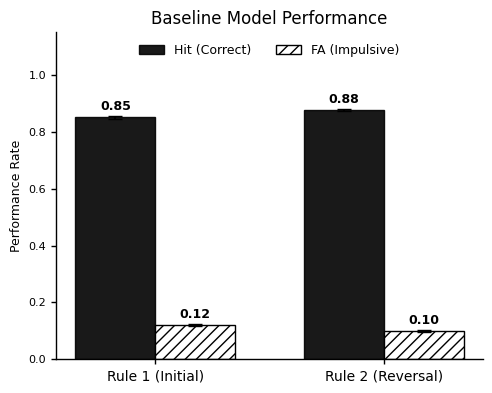

In [ ]:
# =========================================
# Cell 12-B: Baseline Detailed Performance (R1 vs R2)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# [SETUP] Ensure SAVE_DIR is a Path object
if 'SAVE_DIR' not in locals():
    SAVE_DIR = Path('.') # Default to current dir if not set
else:
    SAVE_DIR = Path(SAVE_DIR)

# --- 1. Helper Function (Same as Cell 12) ---
def save_vec(fig, stem: Path):
    """
    Saves figure in multiple formats (SVG/PDF for editing, PNG for preview).
    """
    # Ensure directory exists
    stem.parent.mkdir(parents=True, exist_ok=True)

    # Save vector formats for papers
    fig.savefig(stem.with_suffix(".svg"), bbox_inches="tight", transparent=True)
    fig.savefig(stem.with_suffix(".pdf"), bbox_inches="tight", transparent=True)
    # Save raster format for preview
    fig.savefig(stem.with_suffix(".png"), bbox_inches="tight", dpi=150, transparent=False, facecolor='white')
    print(f"[SAVED] {stem.name} (.pdf, .svg, .png)")

# --- 2. Data Preparation ---
# Check if 'all_cond' exists. If not, run quick baseline.
if 'all_cond' not in locals() or 'control' not in all_cond:
    print("[INFO] 'all_cond' data missing. Running quick Baseline Simulation...")
    SimConfig.STIM_SIGMA = 0.15
    tmp_logs = []
    QUICK_SEEDS = list(range(10))
    for s in QUICK_SEEDS:
        _, l = train_simulation(500, 100, seed=s, ppc_model_class=ParallelPPC)
        tmp_logs.append(l)

    def _stack(list_of_lists): return np.stack(list_of_lists)
    metrics = ["hit", "fa", "plick5", "plick10"]
    baseline_data = {k: _stack([L[k] for L in tmp_logs]) for k in metrics}
    SWITCH_PT = 100
else:
    print("[INFO] Using existing 'all_cond' data from Cell 11.")
    baseline_data = all_cond['control']
    SWITCH_PT = SWITCH

# --- 3. Calculate Stats ---
trace_len = baseline_data["hit"].shape[1]
TAIL_WIN = 50

# Indices: R1 (Before Switch) vs R2 (End of Task)
r1_start, r1_end = SWITCH_PT - TAIL_WIN, SWITCH_PT
r2_start, r2_end = trace_len - TAIL_WIN, trace_len

def get_stat(metric_name, start, end):
    trace = baseline_data[metric_name][:, start:end]
    avg_per_seed = trace.mean(axis=1)
    return np.mean(avg_per_seed), np.std(avg_per_seed) / np.sqrt(len(avg_per_seed))

stats = {
    "R1_Hit": get_stat("hit", r1_start, r1_end),
    "R1_FA":  get_stat("fa",  r1_start, r1_end),
    "R2_Hit": get_stat("hit", r2_start, r2_end),
    "R2_FA":  get_stat("fa",  r2_start, r2_end),
}

# --- 4. Visualization ---
fig, ax = plt.subplots(figsize=(5, 4)) # Adjusted size for paper figure

# Plot Settings
labels = ["Rule 1 (Initial)", "Rule 2 (Reversal)"]
x = np.arange(len(labels))
width = 0.35

# Extract Means & SEMs
hit_means = [stats["R1_Hit"][0], stats["R2_Hit"][0]]
hit_sems  = [stats["R1_Hit"][1], stats["R2_Hit"][1]]
fa_means  = [stats["R1_FA"][0], stats["R2_FA"][0]]
fa_sems   = [stats["R1_FA"][1], stats["R2_FA"][1]]

# Draw Bars
# Hit: Black Solid
rects1 = ax.bar(x - width/2, hit_means, width, yerr=hit_sems, capsize=5,
                label='Hit (Correct)', color='black', alpha=0.9, edgecolor='black')
# FA: White with Hatch
rects2 = ax.bar(x + width/2, fa_means, width, yerr=fa_sems, capsize=5,
                label='FA (Impulsive)', color='white', edgecolor='black', hatch='///')

# Labels & Ticks
ax.set_ylabel('Performance Rate')
ax.set_title('Baseline Model Performance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylim(0, 1.15) # Slightly higher for legend space
ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, fontsize=9)

# Value Annotations
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

# Cleanup Spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# --- 5. Save using save_vec style ---
file_stem = SAVE_DIR / "Fig_Baseline_Performance_R1_vs_R2"
save_vec(fig, file_stem)

plt.show()

[INFO] Generating Comparative Bar Plots (Save Dir: /content/drive/MyDrive/figs_v3_parallel_inactivation_only)...
[SAVED] Bar_Compare_Control_vs_ac_inact (.pdf, .svg, .png)


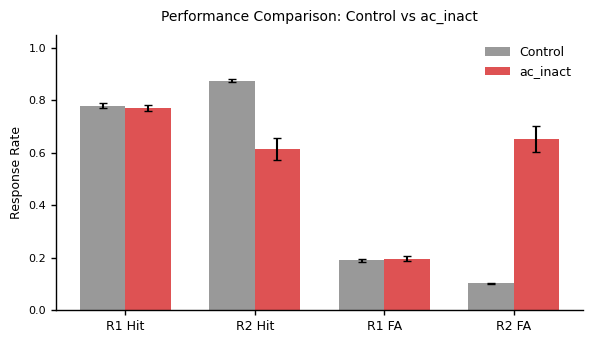

[SAVED] Bar_Compare_Control_vs_ic_inact (.pdf, .svg, .png)


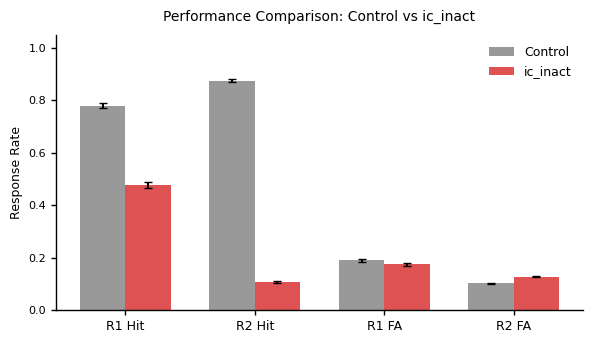

[SAVED] Bar_Compare_Control_vs_ppcac_inact (.pdf, .svg, .png)


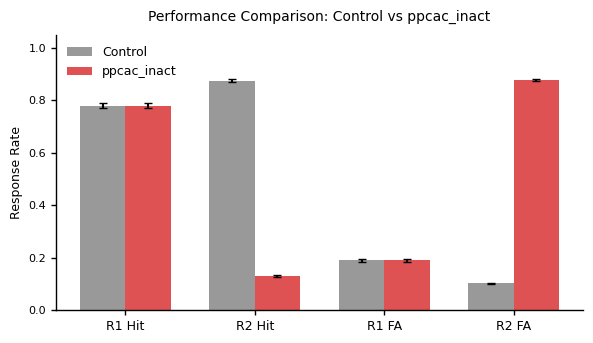

[SAVED] Bar_Compare_Control_vs_ppcic_inact (.pdf, .svg, .png)


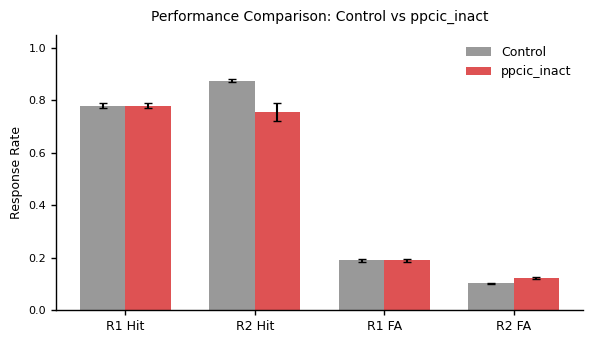

[DONE] Comparative figures saved to: /content/drive/MyDrive/figs_v3_parallel_inactivation_only


In [ ]:
# =========================================
# Cell 13: Control vs. Condition Comparative Analysis (Hit/FA)
# =========================================

def collect_hit_fa_control_vs_cond(all_cond, cond_name, switch, tail):
    """
    Aggregates Mean ± SEM for Hit and FA rates at the end of R1 and R2.
    Returns a nested dictionary structure.
    """
    out = {}

    # Iterate over Control and the specific Target Condition
    for label in ["control", cond_name]:
        if label not in all_cond:
            print(f"[WARN] Missing data for condition: {label}")
            continue

        # Rule 1 End Stats (Check last 'tail' iters before switch)
        hit1_m, hit1_s, _ = end_mean_sem_rule1(all_cond[label]["hit"], switch, tail)
        fa1_m,  fa1_s,  _ = end_mean_sem_rule1(all_cond[label]["fa"],  switch, tail)

        # Rule 2 End Stats (Check last 'tail' iters of the session)
        hit2_m, hit2_s, _ = end_mean_sem_rule2(all_cond[label]["hit"], switch, tail)
        fa2_m,  fa2_s,  _ = end_mean_sem_rule2(all_cond[label]["fa"],  switch, tail)

        out[label] = {
            "R1_Hit": (hit1_m, hit1_s),
            "R2_Hit": (hit2_m, hit2_s),
            "R1_FA":  (fa1_m,  fa1_s),
            "R2_FA":  (fa2_m,  fa2_s),
        }
    return out

def plot_control_vs_condition_hit_fa(cond_name, stats, outdir: Path):
    """
    Plots a grouped bar chart: Control vs. Condition.
    Groups: [R1 Hit, R2 Hit, R1 FA, R2 FA]
    """
    # Define Metrics to Plot
    metrics_order = ["R1_Hit", "R2_Hit", "R1_FA", "R2_FA"]
    x_labels      = ["R1 Hit", "R2 Hit", "R1 FA", "R2 FA"]

    # Extract Data for Control
    ctrl_means = [stats["control"][m][0] for m in metrics_order]
    ctrl_sems  = [stats["control"][m][1] for m in metrics_order]

    # Extract Data for Condition
    cond_means = [stats[cond_name][m][0] for m in metrics_order]
    cond_sems  = [stats[cond_name][m][1] for m in metrics_order]

    # Plot Settings
    x = np.arange(len(x_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3.5))

    # Bars
    # Control: Black/Gray
    rects1 = ax.bar(x - width/2, ctrl_means, width, yerr=ctrl_sems,
                    label="Control", color='gray', alpha=0.8, capsize=3, edgecolor='none')

    # Condition: Red/Colored (to highlight the difference)
    rects2 = ax.bar(x + width/2, cond_means, width, yerr=cond_sems,
                    label=cond_name, color='tab:red', alpha=0.8, capsize=3, edgecolor='none')

    # Styling
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Response Rate")
    ax.set_title(f"Performance Comparison: Control vs {cond_name}", fontsize=10, pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, fontsize=9)
    ax.legend(frameon=False, fontsize=9)

    # Aesthetic Cleanup
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a horizontal line at 0.5 (Chance level) for reference? Optional.
    # ax.axhline(0.5, color='black', linestyle=':', linewidth=0.5, alpha=0.5)

    plt.tight_layout()

    # Save using the helper from Cell 12
    save_vec(fig, outdir / f"Bar_Compare_Control_vs_{cond_name}")

    plt.show() # Show explicitly
    # Note: save_vec usually doesn't close fig, but if you modified it,
    # plt.show() ensures you see it in the notebook.

# --- Execution ---

print(f"[INFO] Generating Comparative Bar Plots (Save Dir: {SAVE_DIR})...")

# 1. Identify Target Conditions (exclude control itself)
compare_conds = [spec["name"] for spec in COND_SPECS if spec["name"] != "control"]

# 2. Loop and Plot
for cname in compare_conds:
    # Check if data exists
    if cname not in all_cond or "control" not in all_cond:
        print(f"[SKIP] Missing data for comparison: {cname}")
        continue

    stats = collect_hit_fa_control_vs_cond(
        all_cond,
        cond_name=cname,
        switch=SWITCH,
        tail=TAIL_R2
    )

    plot_control_vs_condition_hit_fa(
        cond_name=cname,
        stats=stats,
        outdir=SAVE_DIR
    )

print(f"[DONE] Comparative figures saved to: {SAVE_DIR.resolve()}")

In [ ]:
# =========================================
# Cell 14: Parallel vs Whole - Main Comparison Experiment (N=20)
# =========================================
import os
import numpy as np
import torch
import time

# --- 1. State Management Helpers (Bug Fix & Standardization) ---

def save_wppc_state(wppc):
    """Saves dynamic state (goal_ema) of WholePPC."""
    return {"goal_ema": float(getattr(wppc, "goal_ema", 0.0))}

def load_wppc_state(wppc, state: dict):
    if not state: return
    if "goal_ema" in state and hasattr(wppc, "goal_ema"):
        wppc.goal_ema = float(state["goal_ema"])

def save_ppc_state(ppc):
    """Saves dynamic state (goal_ema) of ParallelPPC (ParallelPPC)."""
    return {"goal_ema": float(getattr(ppc, "goal_ema", 0.0))}

def load_ppc_state(ppc, state: dict):
    if not state: return
    if "goal_ema" in state and hasattr(ppc, "goal_ema"):
        ppc.goal_ema = float(state["goal_ema"])

# --- 2. Configuration ---
SEEDS = list(range(20))
NSEED = len(SEEDS)

SIGMA_SIM = 0.15   # Standard Noise Condition
INIT_ITERS, PHASE1_ADDIT, PHASE2_ITERS = 50, 50, 300
PHASE1_ITERS = INIT_ITERS + PHASE1_ADDIT
TOTAL_ITERS  = PHASE1_ITERS + PHASE2_ITERS
SWITCH       = PHASE1_ITERS

TAIL_END = 100  # Window for end-phase metrics

# Matched-Stop Experiment Config
R1_STOP_THRESH = 0.2
R1_MAX_ITERS   = 2000
REV_ONLY_ITERS = 400
REV_WIN50      = 100
REV_THRESH     = 0.2
EMA_BETA       = 0.95

print(f"[CONFIG] Sigma={SIGMA_SIM}, Seeds={NSEED}, Total={TOTAL_ITERS} (Switch={SWITCH})")
print(f"[CONFIG] Matched-Stop: Thresh={R1_STOP_THRESH}, Rev_Iters={REV_ONLY_ITERS}")


# --- 3. Experiment Part A: Full Run with Fixed Switch ---
# Using the engine from Cell 10/11 for consistency

def run_full_collect_v3(kind, seed):
    """Wrapper to run full simulation using standardized engine."""
    # Reuse 'train_with_rulebased_ppc_events_collect' but adapt for Model Type

    # Note: The engine in Cell 10 defaults to ParallelPPC (ParallelPPC).
    # To support WholePPC, we need to temporarily inject or swap the class.
    # Here, we'll use the specific functions defined in Cell 3 for flexibility.

    if kind == "whole":
        return train_whole_collect(TOTAL_ITERS, SWITCH, seed=seed, sigma=SIGMA_SIM)
    elif kind == "parallel":
        return train_parallel_collect(TOTAL_ITERS, SWITCH, seed=seed, sigma=SIGMA_SIM)
    else:
        raise ValueError("kind must be 'whole' or 'parallel'")

def stack_full(kind):
    print(f"  > Running Full Simulation: {kind.upper()} ...", end="", flush=True)
    t0 = time.time()
    p5, p10, rew = [], [], []

    for sd in SEEDS:
        logs = run_full_collect_v3(kind, sd)
        p5.append(logs["plick5"])
        p10.append(logs["plick10"])
        rew.append(logs["reward"])

    print(f" Done ({time.time()-t0:.1f}s)")
    return {
        "plick5": np.array(p5, dtype=float),
        "plick10": np.array(p10, dtype=float),
        "reward": np.array(rew, dtype=float),
    }

print("\n[PART A] Running Fixed-Switch Experiments...")
full_whole = stack_full("whole")
full_par   = stack_full("parallel")

# Calculate End-Phase Metrics (Hit/FA)
def phase_end_metrics(full):
    p5 = full["plick5"]
    p10 = full["plick10"]

    # Rule 1 End: Go=5kHz (p5 is Hit, p10 is FA)
    sl1 = slice(max(0, SWITCH-TAIL_END), SWITCH)
    hit1 = np.nanmean(p5[:, sl1], axis=1)
    fa1  = np.nanmean(p10[:, sl1], axis=1)

    # Rule 2 End: Go=10kHz (p10 is Hit, p5 is FA)
    sl2 = slice(max(0, TOTAL_ITERS-TAIL_END), TOTAL_ITERS)
    hit2 = np.nanmean(p10[:, sl2], axis=1)
    fa2  = np.nanmean(p5[:, sl2], axis=1)

    return {"hit1": hit1, "fa1": fa1, "hit2": hit2, "fa2": fa2}

end_whole = phase_end_metrics(full_whole)
end_par   = phase_end_metrics(full_par)


# --- 4. Experiment Part B: Matched Phase 1 Stop ---
# Using the threshold-based training from Cell 5/6

print("\n[PART B] Running Matched-Stop Experiments...")

# Metric Helper
def ema_first_crossing(reward_trace, thresh=0.2, ema_beta=0.95):
    ema = 0.0
    for t, r in enumerate(reward_trace):
        ema = ema_beta * ema + (1.0 - ema_beta) * float(r)
        if ema >= thresh:
            return t
    return np.nan

# Containers
r2_whole_list, r2_par_list = [], []
r1_tstop_whole, r1_tstop_par = [], []

# Metrics for Analysis
r2_reward50_whole, r2_reward50_par = [], []
r2_tth_whole, r2_tth_par = [], []

print("  > Processing Seeds: ", end="")
for i, sd in enumerate(SEEDS):
    if i % 5 == 0: print(f"{sd}..", end="", flush=True)

    # 1. Whole PPC
    ckpt_w, _, tstop_w = train_whole_rule1_to_threshold(
        thresh=R1_STOP_THRESH, max_iters=R1_MAX_ITERS, sigma=SIGMA_SIM, seed=sd
    )

    r2_w = run_reversal_only_whole_from_checkpoint(ckpt_w, iters_reversal=REV_ONLY_ITERS, sigma=SIGMA_SIM, seed=sd)

    # 2. Parallel PPC
    ckpt_p, _, tstop_p = train_parallel_rule1_to_threshold(
        thresh=R1_STOP_THRESH, max_iters=R1_MAX_ITERS, sigma=SIGMA_SIM, seed=sd
    )
    r2_p = run_reversal_only_parallel_from_checkpoint(ckpt_p, iters_reversal=REV_ONLY_ITERS, sigma=SIGMA_SIM, seed=sd)

    # Store
    r2_whole_list.append(r2_w)
    r2_par_list.append(r2_p)
    r1_tstop_whole.append(tstop_w)
    r1_tstop_par.append(tstop_p)

    # Metrics
    r2_reward50_whole.append(np.mean(r2_w["reward"][:REV_WIN50]))
    r2_reward50_par.append(np.mean(r2_p["reward"][:REV_WIN50]))

    r2_tth_whole.append(ema_first_crossing(r2_w["reward"], thresh=REV_THRESH, ema_beta=EMA_BETA))
    r2_tth_par.append(ema_first_crossing(r2_p["reward"], thresh=REV_THRESH, ema_beta=EMA_BETA))

print(" Done.")

# Stack Data
rev_whole = {
    "plick5": _stack([d["plick5"] for d in r2_whole_list]),
    "plick10": _stack([d["plick10"] for d in r2_whole_list]),
    "reward": _stack([d["reward"] for d in r2_whole_list]),
}
rev_par = {
    "plick5": _stack([d["plick5"] for d in r2_par_list]),
    "plick10": _stack([d["plick10"] for d in r2_par_list]),
    "reward": _stack([d["reward"] for d in r2_par_list]),
}

# --- 5. Summary & Save ---
summary = {
    "config": dict(SIGMA_SIM=SIGMA_SIM, SEEDS=SEEDS, TOTAL_ITERS=TOTAL_ITERS, SWITCH=SWITCH,
                   R1_STOP_THRESH=R1_STOP_THRESH, REV_ONLY_ITERS=REV_ONLY_ITERS),
    "full_whole": full_whole,
    "full_par": full_par,
    "end_whole": end_whole,
    "end_par": end_par,
    "rev_whole": rev_whole,
    "rev_par": rev_par,
    "r1_tstop_whole": np.array(r1_tstop_whole, dtype=float),
    "r1_tstop_par": np.array(r1_tstop_par, dtype=float),
    "r2_reward50_whole": np.array(r2_reward50_whole, dtype=float),
    "r2_reward50_par": np.array(r2_reward50_par, dtype=float),
    "r2_tth_whole": np.array(r2_tth_whole, dtype=float),
    "r2_tth_par": np.array(r2_tth_par, dtype=float),
}

OUT_NPZ = os.path.join(SAVE_DIR, "summary_parallel_vs_whole.npz")
np.savez_compressed(
    OUT_NPZ,
    **{k: summary[k] for k in summary if k != "config"},
    config=str(summary["config"])
)

print("-" * 60)
print(f"[DONE] Experiments Completed.")
print(f"       Saved Data: {OUT_NPZ}")
print(f"       Full Curves Shape: {summary['full_par']['plick5'].shape}")
print(f"       Rev Curves Shape:  {summary['rev_par']['plick5'].shape}")

[CONFIG] Sigma=0.15, Seeds=20, Total=400 (Switch=100)
[CONFIG] Matched-Stop: Thresh=0.2, Rev_Iters=400

[PART A] Running Fixed-Switch Experiments...
  > Running Full Simulation: WHOLE ... Done (62.2s)
  > Running Full Simulation: PARALLEL ... Done (60.0s)

[PART B] Running Matched-Stop Experiments...
  > Processing Seeds: 0..5..10..15.. Done.
------------------------------------------------------------
[DONE] Experiments Completed.
       Saved Data: /content/drive/MyDrive/figs_v3_parallel_inactivation_only/summary_parallel_vs_whole.npz
       Full Curves Shape: (20, 400)
       Rev Curves Shape:  (20, 400)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Figures will be saved to: /content/drive/MyDrive/fig_parallel_vs_whole
[CONFIG] Loaded: Tail=50, Win50=50, Thresh=0.2
Saved: G1_full_plick_overlay


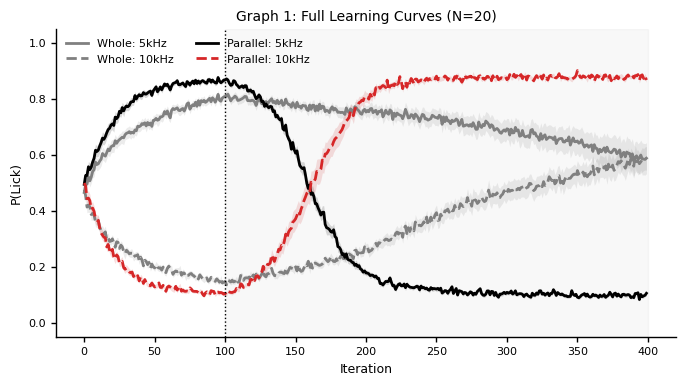

Saved: G2_phase1_end


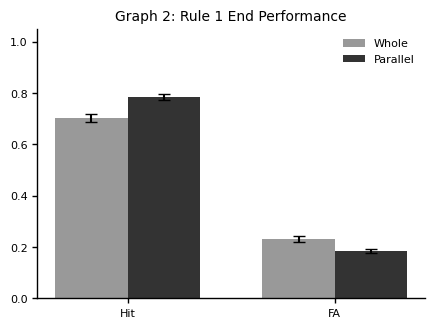

Saved: G3_phase2_end


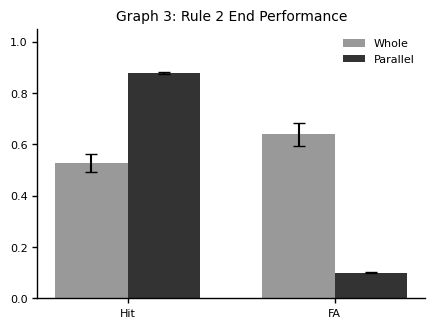

Saved: G4_reversal_only


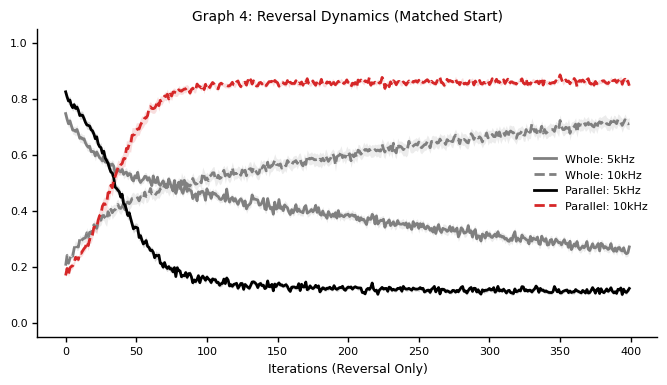

Saved: G5_G6_Reversal_Metrics


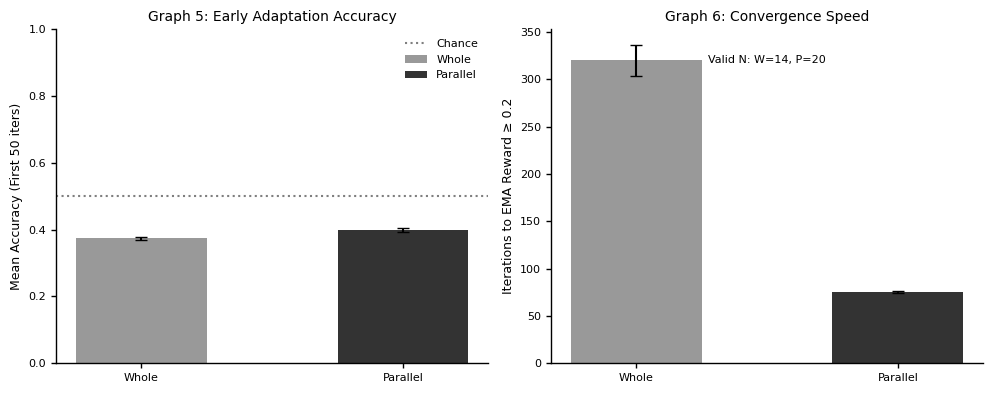

[DONE] All figures generated in: /content/drive/MyDrive/fig_parallel_vs_whole


In [ ]:
# =========================================
# Cell 16: Final Visualization (Parallel vs Whole) with Save Options
# =========================================
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if SAVE_FLAG:
    from google.colab import drive
    drive.mount('/content/drive')
    FIG_DIR = Path("/content/drive/MyDrive/fig_parallel_vs_whole")
else:
    FIG_DIR = Path("fig_parallel_vs_whole")

FIG_DIR.mkdir(parents=True, exist_ok=True)
print(f"[INFO] Figures will be saved to: {FIG_DIR}")

# --- 2. Plotting Setup ---
plt.rcParams.update({
    "svg.fonttype": "none",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 9,
    "axes.spines.top": False,
    "axes.spines.right": False
})

def save_fig(fig, basename):
    stem = FIG_DIR / basename
    fig.savefig(stem.with_suffix(".svg"), bbox_inches="tight", transparent=True)
    fig.savefig(stem.with_suffix(".pdf"), bbox_inches="tight", transparent=True)
    fig.savefig(stem.with_suffix(".png"), bbox_inches="tight", dpi=150, facecolor='white')
    print(f"Saved: {stem.name}")

def mean_sem(x, axis=0):
    x = np.asarray(x, dtype=float)
    m = np.nanmean(x, axis=axis)
    valid_count = np.sum(~np.isnan(x), axis=axis)
    s = np.nanstd(x, axis=axis, ddof=1) / np.sqrt(valid_count)
    return m, s

def plot_curve(ax, x, mean, sem, label, color=None, ls='-'):
    l, = ax.plot(x, mean, label=label, linewidth=2, color=color, linestyle=ls)
    ax.fill_between(x, mean-sem, mean+sem, alpha=0.15, color=l.get_color(), lw=0)

def grouped_bars(ax, labels, a_mean, a_sem, b_mean, b_sem, a_name="Whole", b_name="Parallel"):
    x = np.arange(len(labels))
    w = 0.35
    ax.bar(x - w/2, a_mean, yerr=a_sem, capsize=4, width=w, label=a_name, color='gray', alpha=0.8)
    ax.bar(x + w/2, b_mean, yerr=b_sem, capsize=4, width=w, label=b_name, color='black', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)


# --- 3. Ensure Data is Loaded ---
if 'summary' not in locals():
    try:
        load_path = FIG_DIR / "summary_parallel_vs_whole.npz"
        if not load_path.exists() and SAVE_FLAG:
             load_path = Path("/content/drive/MyDrive/figs_v3_parallel_inactivation_only/summary_parallel_vs_whole.npz")

        if load_path.exists():
            data = np.load(load_path, allow_pickle=True)
            summary = {k: data[k].item() if data[k].ndim==0 else data[k] for k in data.files}
            if isinstance(summary['config'], str): summary['config'] = eval(summary['config'])
            print(f"[INFO] Loaded summary data from {load_path}")
        else:
            print("[WARN] 'summary' data not found. Please run Cell 14 first.")
    except Exception as e:
        print(f"[ERROR] Data load failed: {e}")

cfg = summary["config"]

# [FIX] Use .get() with defaults to prevent KeyError if keys were missed in Cell 14
TOTAL_ITERS = cfg.get("TOTAL_ITERS", 400)
SWITCH = cfg.get("SWITCH", 100)
TAIL_END = cfg.get("TAIL_END", 50)          # Fixed
REV_ONLY_ITERS = cfg.get("REV_ONLY_ITERS", 400)
REV_WIN50 = cfg.get("REV_WIN50", 50)        # Fixed
REV_THRESH = cfg.get("REV_THRESH", 0.2)     # Fixed
SIGMA_SIM = cfg.get("SIGMA_SIM", 0.15)
SEEDS = cfg.get("SEEDS", list(range(20)))   # Fixed
NSEEDS = len(SEEDS)

print(f"[CONFIG] Loaded: Tail={TAIL_END}, Win50={REV_WIN50}, Thresh={REV_THRESH}")

# =========================
# Graph 1: Full Learning Curves (Overlay)
# =========================
x = np.arange(TOTAL_ITERS)
w_p5_m, w_p5_s = mean_sem(summary["full_whole"]["plick5"])
w_p10_m, w_p10_s = mean_sem(summary["full_whole"]["plick10"])
p_p5_m, p_p5_s = mean_sem(summary["full_par"]["plick5"])
p_p10_m, p_p10_s = mean_sem(summary["full_par"]["plick10"])

fig, ax = plt.subplots(figsize=(8, 4))
plot_curve(ax, x, w_p5_m, w_p5_s, "Whole: 5kHz", color='gray')
plot_curve(ax, x, w_p10_m, w_p10_s, "Whole: 10kHz", color='gray', ls='--')
plot_curve(ax, x, p_p5_m, p_p5_s, "Parallel: 5kHz", color='black')
plot_curve(ax, x, p_p10_m, p_p10_s, "Parallel: 10kHz", color='tab:red', ls='--')

ax.axvline(SWITCH, linestyle=":", linewidth=1, color='black')
ax.axvspan(SWITCH, TOTAL_ITERS, color='gray', alpha=0.05)
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("Iteration")
ax.set_ylabel("P(Lick)")
ax.set_title(f"Graph 1: Full Learning Curves (N={NSEEDS})")
ax.legend(frameon=False, loc='upper left', ncol=2, fontsize=8)
save_fig(fig, "G1_full_plick_overlay")
plt.show()

# =========================
# Graph 2 & 3: Phase End Performance
# =========================
def plot_end_perf(hit_key, fa_key, title, fname):
    hit_w, fa_w = summary["end_whole"][hit_key], summary["end_whole"][fa_key]
    hit_p, fa_p = summary["end_par"][hit_key], summary["end_par"][fa_key]

    labels = ["Hit", "FA"]
    w_m = [np.mean(hit_w), np.mean(fa_w)]
    w_s = [np.std(hit_w, ddof=1)/np.sqrt(len(hit_w)), np.std(fa_w, ddof=1)/np.sqrt(len(fa_w))]
    p_m = [np.mean(hit_p), np.mean(fa_p)]
    p_s = [np.std(hit_p, ddof=1)/np.sqrt(len(hit_p)), np.std(fa_p, ddof=1)/np.sqrt(len(fa_p))]

    fig, ax = plt.subplots(figsize=(5, 3.5))
    grouped_bars(ax, labels, w_m, w_s, p_m, p_s)
    ax.set_ylim(0, 1.05)
    ax.set_title(title)
    ax.legend(frameon=False)
    save_fig(fig, fname)
    plt.show()

plot_end_perf("hit1", "fa1", "Graph 2: Rule 1 End Performance", "G2_phase1_end")
plot_end_perf("hit2", "fa2", "Graph 3: Rule 2 End Performance", "G3_phase2_end")

# =========================
# Graph 4: Reversal-Only Curves
# =========================
xr = np.arange(REV_ONLY_ITERS)
rw_p5_m, rw_p5_s = mean_sem(summary["rev_whole"]["plick5"])
rw_p10_m, rw_p10_s = mean_sem(summary["rev_whole"]["plick10"])
rp_p5_m, rp_p5_s = mean_sem(summary["rev_par"]["plick5"])
rp_p10_m, rp_p10_s = mean_sem(summary["rev_par"]["plick10"])

fig, ax = plt.subplots(figsize=(8, 4))
plot_curve(ax, xr, rw_p5_m, rw_p5_s, "Whole: 5kHz", color='gray')
plot_curve(ax, xr, rw_p10_m, rw_p10_s, "Whole: 10kHz", color='gray', ls='--')
plot_curve(ax, xr, rp_p5_m, rp_p5_s, "Parallel: 5kHz", color='black')
plot_curve(ax, xr, rp_p10_m, rp_p10_s, "Parallel: 10kHz", color='tab:red', ls='--')

ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("Iterations (Reversal Only)")
ax.set_title("Graph 4: Reversal Dynamics (Matched Start)")
ax.legend(frameon=False, loc='center right', fontsize=8)
save_fig(fig, "G4_reversal_only")
plt.show()
# =========================
# Graph 5 & 6: Reversal Metrics (Side-by-Side)
# =========================
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # 1행 2열 프레임 생성

# --- [Graph 5] Early Reversal Accuracy (Left) ---
# Reversal(Rule 2) Accuracy = (Hit(10k) + CR(5k)) / 2
# Hit = plick10, CR = 1 - plick5

# 1. Calculate Accuracy Trace
w_p10 = summary["rev_whole"]["plick10"]
w_p5  = summary["rev_whole"]["plick5"]
w_acc_trace = (w_p10 + (1.0 - w_p5)) / 2.0

p_p10 = summary["rev_par"]["plick10"]
p_p5  = summary["rev_par"]["plick5"]
p_acc_trace = (p_p10 + (1.0 - p_p5)) / 2.0

# 2. Mean over first 50 iters
w_early_acc = np.mean(w_acc_trace[:, :REV_WIN50], axis=1)
p_early_acc = np.mean(p_acc_trace[:, :REV_WIN50], axis=1)

# 3. Stats
wm, ws = mean_sem(w_early_acc)
pm, ps = mean_sem(p_early_acc)

# 4. Plot on axes[0]
ax = axes[0]
ax.bar([0], [wm], yerr=[ws], capsize=4, width=0.5, label="Whole", color='gray', alpha=0.8)
ax.bar([1], [pm], yerr=[ps], capsize=4, width=0.5, label="Parallel", color='black', alpha=0.8)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Whole", "Parallel"])
ax.set_ylabel(f"Mean Accuracy (First {REV_WIN50} iters)")
ax.set_title("Graph 5: Early Adaptation Accuracy")
ax.set_ylim(0, 1.0)
ax.axhline(0.5, ls=':', color='k', alpha=0.5, label='Chance')
ax.legend(frameon=False)


# --- [Graph 6] Time to Threshold (Right) ---
# 1. Data Setup
tw = np.array(summary["r2_tth_whole"], dtype=float)
tp = np.array(summary["r2_tth_par"], dtype=float)

# 2. Stats (ignoring NaNs)
wm = np.nanmean(tw)
pm = np.nanmean(tp)
# Valid count for SEM
w_valid = np.sum(~np.isnan(tw))
p_valid = np.sum(~np.isnan(tp))
ws = np.nanstd(tw, ddof=1) / np.sqrt(w_valid) if w_valid > 0 else 0.0
ps = np.nanstd(tp, ddof=1) / np.sqrt(p_valid) if p_valid > 0 else 0.0

# 3. Plot on axes[1]
ax = axes[1]
ax.bar([0], [wm], yerr=[ws], capsize=4, width=0.5, color='gray', alpha=0.8)
ax.bar([1], [pm], yerr=[ps], capsize=4, width=0.5, color='black', alpha=0.8)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Whole", "Parallel"])
ax.set_ylabel(f"Iterations to EMA Reward ≥ {REV_THRESH}")
ax.set_title("Graph 6: Convergence Speed")

# Add valid count text
ax.text(0.5, 0.9, f"Valid N: W={w_valid}, P={p_valid}",
        transform=ax.transAxes, ha='center', fontsize=8)


# --- Final Layout & Save ---
plt.tight_layout()
save_fig(fig, "G5_G6_Reversal_Metrics")
plt.show()

print(f"[DONE] All figures generated in: {FIG_DIR}")

In [ ]:
# 1. Mount Drive
drive.mount('/content/drive')

# 2. Set Save Path
SAVE_DIR = "/content/drive/My Drive/Neuro_Sim_Results/Final_PDFs"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"[INFO] Saving PDFs to: {SAVE_DIR}")

def save_pdf(filename):
    """Save current figure as PDF"""
    filepath = os.path.join(SAVE_DIR, f"{filename}.pdf")
    plt.savefig(filepath, format='pdf', bbox_inches='tight')
    print(f"  >>> [SAVED PDF] {filepath}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Saving PDFs to: /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs


[INFO] Running Comparison (Target Acc=0.6, Slope=30.0)...
  > Model: Parallel   ... Done.
  > Model: Whole      ... Done.
  > Model: Volatile   ... Done.
  > Model: Rigid      ... Done.
  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/Cell17_Performance_Cost_Comparison.pdf


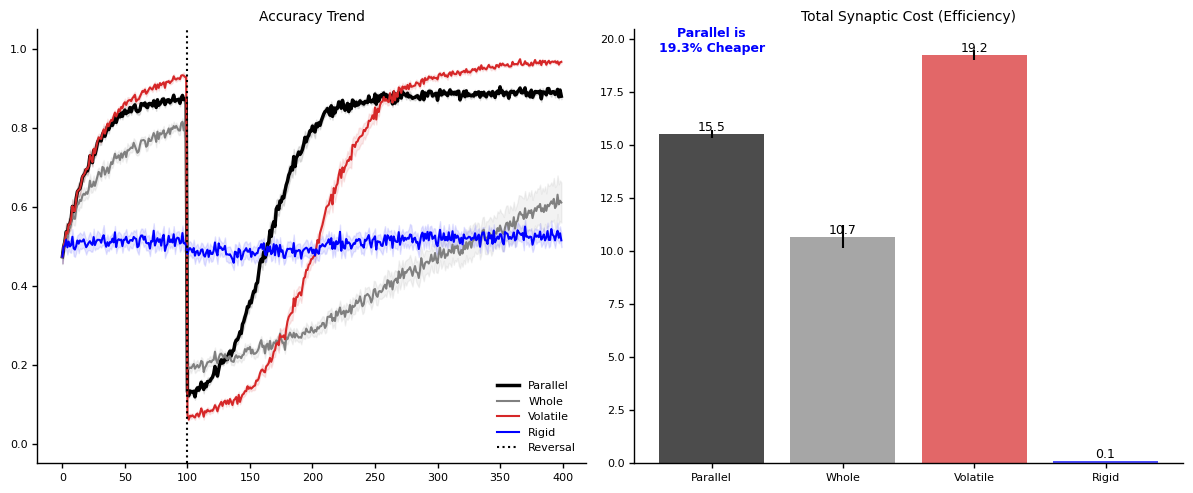

In [ ]:
# =========================================
# Cell 17: Main Comparison (Performance & Cost)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. Experiment Setup ---
COMPARE_ITERS  = 400
COMPARE_SWITCH = 100
COMPARE_SEEDS  = list(range(10))

# --- 2. Define Baselines ---
class ConstantPPC:
    """Baseline: Fixed Gain & Flexibility"""
    def __init__(self, g=1.0, f=0.0): self.g, self.f = g, f
    def update(self, *args, **kwargs): return self.g, self.f, 0.0, 0.0

# Define Models to Compare
# *Note: ParallelPPC uses the standard class from Cell 1
MODELS = {
    "Parallel": ParallelPPC,
    "Whole": WholePPC,
    "Volatile": lambda: ConstantPPC(1.0, 1.0), # Always learn
    "Rigid":    lambda: ConstantPPC(1.0, 0.00001)  # Never learn
}

# --- 3. Run Simulation ---
print(f"[INFO] Running Comparison (Target Acc={SimConfig.PPC_TARGET_ACC}, Slope={SimConfig.PPC_SIGMOID_SLOPE})...")

res_acc = {k: [] for k in MODELS}
res_dw_total = {k: [] for k in MODELS}

for m_name, m_class in MODELS.items():
    print(f"  > Model: {m_name:<10} ...", end="")
    for sd in COMPARE_SEEDS:
        SimConfig.STIM_SIGMA = 0.15 # Ensure Standard Noise
        torch.manual_seed(sd)

        net = FlexStableMLP().to(device)
        ctrl = m_class()
        anchor = clone_state_dict(net)

        trace_acc = []
        total_dw_sum = 0.0
        r_ema = 0.0

        for t in range(COMPARE_ITERS):
            phase = 1 if t < COMPARE_SWITCH else 2
            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)
            go_label = 0 if phase == 1 else 1

            # 1. Forward & Update Control
            with torch.no_grad():
                logits, _, _, _ = net(X, 0.8, 1.0)
                a1 = torch.distributions.Categorical(logits=logits).sample()
                h=((y==go_label)&(a1==0)).sum().item(); m=((y==go_label)&(a1==1)).sum().item()
                f=((y!=go_label)&(a1==0)).sum().item(); c=((y!=go_label)&(a1==1)).sum().item()
                gain, flex, _, _ = ctrl.update(0.0, [h,m,f,c], phase)

            # 2. Training
            w_prev = net.Readout_IC.weight.data.clone()
            logits2, _, _, _ = net(X, gain, 1.0)
            dist2 = torch.distributions.Categorical(logits=logits2); a2 = dist2.sample()
            r = torch.where((y==go_label)&(a2==0), SimConfig.REWARD_GO, torch.where((y!=go_label)&(a2==0), SimConfig.PENALTY_FA, 0.0))

            loss = -((r - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()
            net.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)

            meta_update(net, anchor, build_flexibility_map(net, icro_flex=flex))

            # 3. Log Cost & Acc
            total_dw_sum += (net.Readout_IC.weight.data - w_prev).abs().sum().item()
            acc = ((y==go_label)&(a2==0)).float().sum() + ((y!=go_label)&(a2==1)).float().sum()
            trace_acc.append(acc.item()/X.shape[0])
            r_ema = 0.95*r_ema + 0.05*r.mean().item()

        res_acc[m_name].append(trace_acc)
        res_dw_total[m_name].append(total_dw_sum)
    print(" Done.")

# --- 4. Visualization ---
def ms(d): d=np.array(d); return np.mean(d,0), np.std(d,0)/np.sqrt(d.shape[0])
colors = {"Parallel": "black", "Whole": "gray", "Rigid": "blue", "Volatile": "tab:red"}

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax = axes[0]
for m in MODELS:
    mu, se = ms(res_acc[m])
    ax.plot(mu, label=m, color=colors[m], lw=2.5 if m=="Parallel" else 1.5)
    ax.fill_between(range(len(mu)), mu-se, mu+se, color=colors[m], alpha=0.1)
ax.axvline(COMPARE_SWITCH, color='k', ls=':', label="Reversal")
ax.set_title("Accuracy Trend")
ax.set_ylim(-0.05, 1.05)
ax.legend(frameon=False, loc='lower right')

# Cost
ax = axes[1]
means = [np.mean(res_dw_total[m]) for m in MODELS]
sems  = [np.std(res_dw_total[m])/np.sqrt(len(res_dw_total[m])) for m in MODELS]
bars = ax.bar(MODELS.keys(), means, yerr=sems, color=[colors[m] for m in MODELS], alpha=0.7)
ax.set_title("Total Synaptic Cost (Efficiency)")

# Efficiency Annotation
p_val = means[list(MODELS.keys()).index("Parallel")]
v_val = means[list(MODELS.keys()).index("Volatile")]
if v_val > p_val:
    diff = (v_val - p_val) / v_val * 100
    ax.text(0, v_val, f"Parallel is\n{diff:.1f}% Cheaper", ha='center', va='bottom', color='blue', fontweight='bold')

for b, v in zip(bars, means): ax.text(b.get_x()+b.get_width()/2, v, f"{v:.1f}", ha='center', va='bottom')

plt.tight_layout()
save_pdf("Cell17_Performance_Cost_Comparison") # 파일명 지정
plt.show()

  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/18_Parallel_Internal_Dynamics.pdf


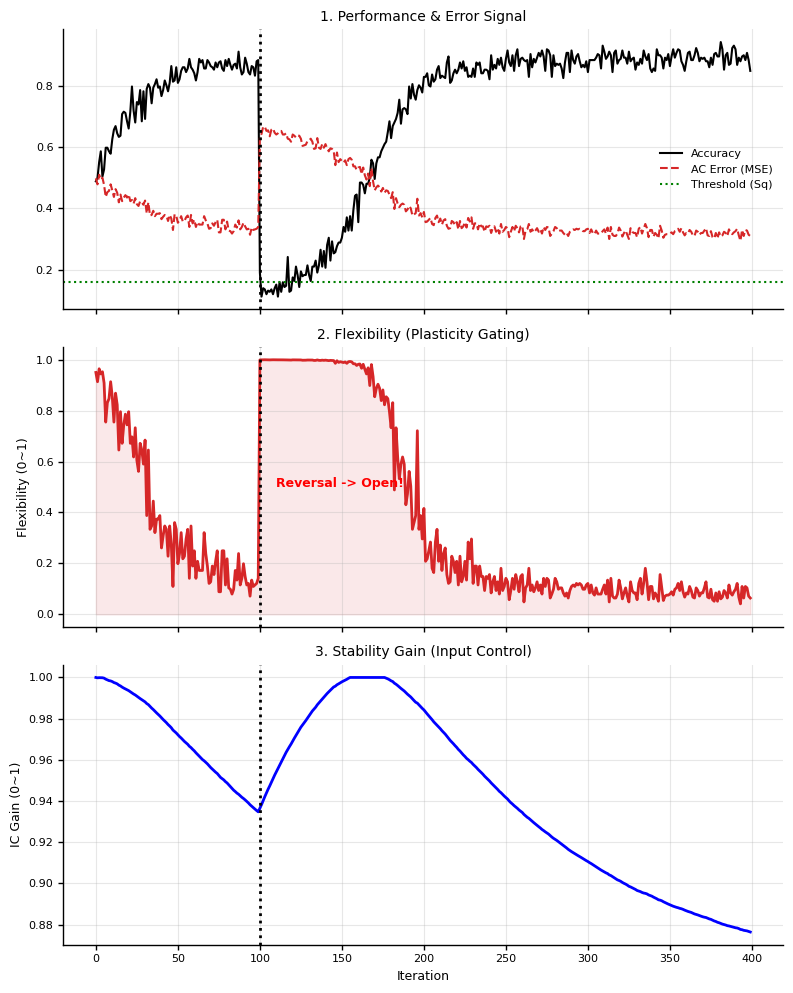

In [ ]:
# =========================================
# Cell 18: Parallel Mechanism Diagnostic
# =========================================
# Goal: Visualize how Sigmoid Logic reacts to Reversal
# =========================================

# --- 1. Run Single High-Res Simulation ---
DIAG_SEEDS = list(range(10))
SEED_IDX    = 0 # Pick one representative seed

SimConfig.STIM_SIGMA = 0.15
torch.manual_seed(SEED_IDX)

net = FlexStableMLP().to(device)
ctrl = ParallelPPC() # Use Standard Cell 1 Class
anchor = clone_state_dict(net)

traces = {"ac_err": [], "ac_flex": [], "ic_gain": [], "acc": []}
r_ema = 0.0

for t in range(COMPARE_ITERS):
    phase = 1 if t < COMPARE_SWITCH else 2
    X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
    X, y = X.to(device), y.to(device)
    go_label = 0 if phase == 1 else 1

    # Update PPC
    with torch.no_grad():
        logits, _, _, _ = net(X, 0.8, 1.0)
        a1 = torch.distributions.Categorical(logits=logits).sample()
        h=((y==go_label)&(a1==0)).sum().item(); m=((y==go_label)&(a1==1)).sum().item()
        f=((y!=go_label)&(a1==0)).sum().item(); c=((y!=go_label)&(a1==1)).sum().item()
        gain, flex, _, ac_err_val = ctrl.update(0.0, [h,m,f,c], phase)

    # Store Traces
    traces["ac_err"].append(ac_err_val)   # MSE
    traces["ac_flex"].append(flex)        # Sigmoid Output
    traces["ic_gain"].append(gain)        # Stability

    # Training
    logits2, _, _, _ = net(X, gain, 1.0)
    dist2 = torch.distributions.Categorical(logits=logits2); a2 = dist2.sample()
    r = torch.where((y==go_label)&(a2==0), SimConfig.REWARD_GO, torch.where((y!=go_label)&(a2==0), SimConfig.PENALTY_FA, 0.0))
    loss = -((r - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()
    net.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
    meta_update(net, anchor, build_flexibility_map(net, icro_flex=flex))

    acc = ((y==go_label)&(a2==0)).float().sum() + ((y!=go_label)&(a2==1)).float().sum()
    traces["acc"].append(acc.item()/X.shape[0])
    r_ema = 0.95*r_ema + 0.05*r.mean().item()

# --- 2. Visualization ---
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Plot 1: Accuracy & Error
ax = axes[0]
ax.plot(traces["acc"], color='black', label='Accuracy', lw=1.5)
ax.plot(traces["ac_err"], color='tab:red', label='AC Error (MSE)', lw=1.5, ls='--')
ax.axhline((1-SimConfig.PPC_TARGET_ACC)**2, color='green', ls=':', label='Threshold (Sq)')
ax.set_title("1. Performance & Error Signal")
ax.legend(loc='center right', frameon=False)

# Plot 2: Flexibility (Sigmoid Response)
ax = axes[1]
ax.plot(traces["ac_flex"], color='tab:red', lw=2)
ax.fill_between(range(len(traces["ac_flex"])), 0, traces["ac_flex"], color='tab:red', alpha=0.1)
ax.set_ylabel("Flexibility (0~1)")
ax.set_title("2. Flexibility (Plasticity Gating)")
ax.text(COMPARE_SWITCH+10, 0.5, "Reversal -> Open!", color='red', fontweight='bold')

# Plot 3: Gain (Stability)
ax = axes[2]
ax.plot(traces["ic_gain"], color='blue', lw=2)
ax.set_ylabel("IC Gain (0~1)")
ax.set_title("3. Stability Gain (Input Control)")
ax.set_xlabel("Iteration")

for ax in axes:
    ax.axvline(COMPARE_SWITCH, color='k', ls=':', lw=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
save_pdf("18_Parallel_Internal_Dynamics")
plt.show()

<>:73: SyntaxWarning: invalid escape sequence '\D'
<>:73: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-653499398.py:73: SyntaxWarning: invalid escape sequence '\D'
  ax2.plot(x, dw_m, color='tab:red', lw=1.5, ls='-', label="$\Delta W$")


[INFO] Running Individual Dynamics (N=10)...
  > Analyzing: Parallel ... Done.
  > Analyzing: Whole ... Done.
  > Analyzing: Volatile ... Done.
  > Analyzing: Rigid ... Done.
  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/19_Inactivation_Check.pdf


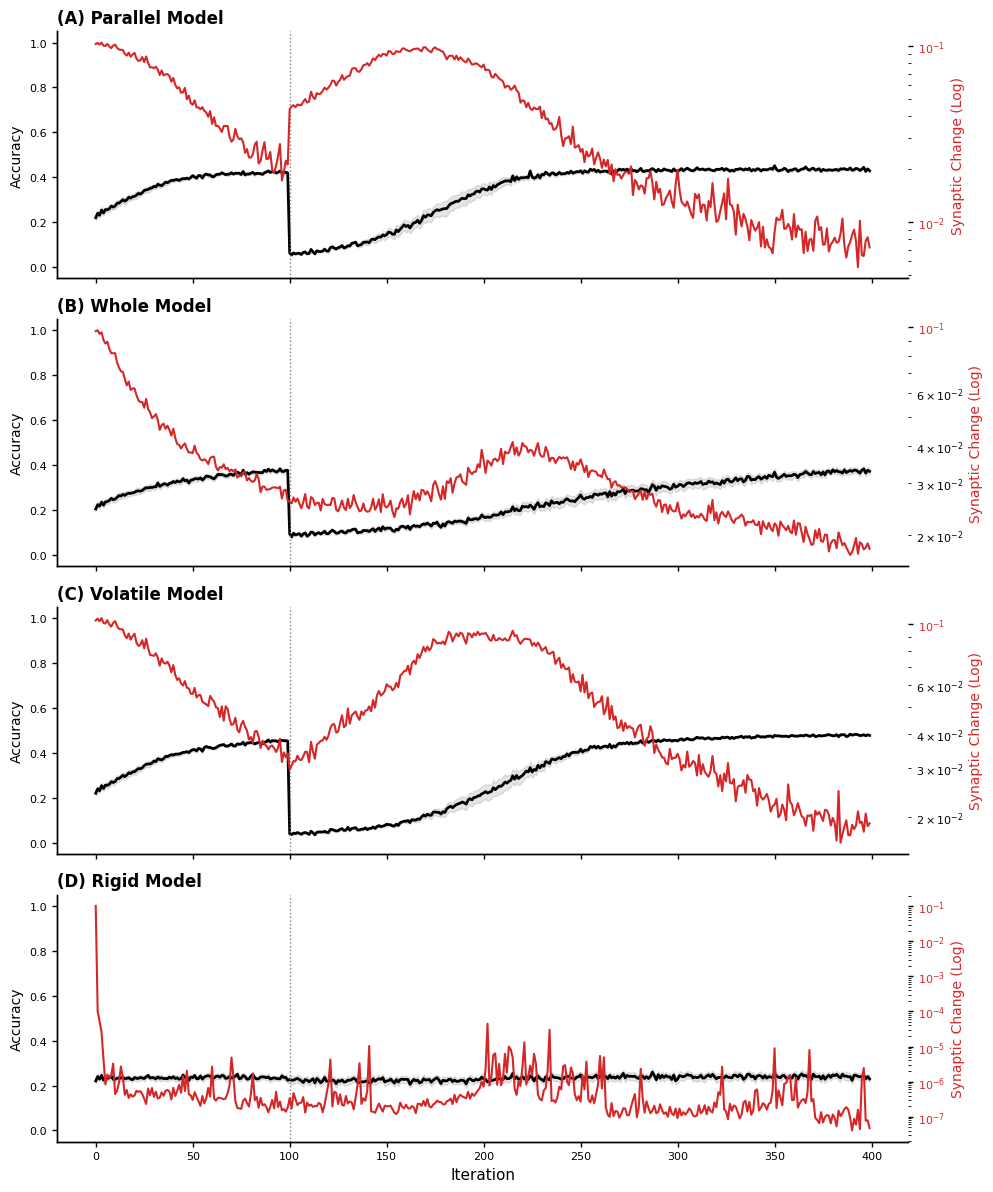

In [ ]:
# =========================================
# Cell 19: Time-Aligned Dynamics (One Plot Per Network) - FIXED
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

print(f"[INFO] Running Individual Dynamics (N={len(DIAG_SEEDS)})...")
model_names = ["Parallel", "Whole", "Volatile", "Rigid"]

results = {m: {"acc": [], "dw": []} for m in model_names}

for m_name in model_names:
    m_class = MODELS[m_name]
    print(f"  > Analyzing: {m_name} ...", end="")

    for sd in DIAG_SEEDS:
        SimConfig.STIM_SIGMA = 1
        torch.manual_seed(sd)
        net = FlexStableMLP().to(device); ctrl = m_class(); anchor = clone_state_dict(net)

        trace_acc, trace_dw = [], []
        r_ema = 0.0

        for t in range(COMPARE_ITERS):
            phase = 1 if t < COMPARE_SWITCH else 2
            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA); X, y = X.to(device), y.to(device)
            go_label = 0 if phase == 1 else 1

            with torch.no_grad():
                logits, _, _, _ = net(X, 0.8, 1.0)
                # [FIX] logits=logits
                a1 = torch.distributions.Categorical(logits=logits).sample()
                h = ((y==go_label)&(a1==0)).sum().item(); m = ((y==go_label)&(a1==1)).sum().item()
                f = ((y!=go_label)&(a1==0)).sum().item(); c = ((y!=go_label)&(a1==1)).sum().item()
                gain, flex, _, _ = ctrl.update(0.0, [h,m,f,c], phase)

            w_prev = net.Readout_IC.weight.data.clone()
            logits2, _, _, _ = net(X, gain, 1.0)
            # [FIX] logits=logits2
            dist2 = torch.distributions.Categorical(logits=logits2); a2 = dist2.sample()
            r = torch.where((y==go_label)&(a2==0), SimConfig.REWARD_GO, torch.where((y!=go_label)&(a2==0), SimConfig.PENALTY_FA, 0.0))
            loss = -((r - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()
            net.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
            meta_update(net, anchor, build_flexibility_map(net, icro_flex=flex))

            trace_dw.append((net.Readout_IC.weight.data - w_prev).abs().sum().item())
            trace_acc.append(((y==go_label)&(a2==0)).float().sum().item() / X.shape[0])
            r_ema = 0.95*r_ema + 0.05*r.mean().item()

        results[m_name]["acc"].append(trace_acc)
        results[m_name]["dw"].append(trace_dw)
    print(" Done.")

# --- Visualization (4 Rows, Dual Axis) ---
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
x = np.arange(COMPARE_ITERS)

def plot_dual(ax, acc_data, dw_data, title, is_last=False):
    acc_m, acc_s = np.mean(acc_data, 0), np.std(acc_data, 0)/np.sqrt(len(acc_data))
    dw_m, dw_s   = np.mean(dw_data, 0), np.std(dw_data, 0)/np.sqrt(len(dw_data))
    dw_m = dw_m + 1e-9

    # Left Axis: Accuracy
    ax.plot(x, acc_m, color='black', lw=2, label="Accuracy")
    ax.fill_between(x, acc_m-acc_s, acc_m+acc_s, color='black', alpha=0.1)
    ax.set_ylabel("Accuracy", color='black', fontsize=10)
    ax.tick_params(axis='y', labelcolor='black')
    ax.set_ylim(-0.05, 1.05)

    # Right Axis: Delta W
    ax2 = ax.twinx()
    ax2.plot(x, dw_m, color='tab:red', lw=1.5, ls='-', label="$\Delta W$")
    ax2.set_ylabel("Synaptic Change (Log)", color='tab:red', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_yscale('log')

    ax.axvline(COMPARE_SWITCH, color='gray', ls=':', lw=1)
    ax.set_title(title, fontsize=12, fontweight='bold', loc='left')
    ax.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    if is_last: ax.set_xlabel("Iteration", fontsize=11)

for i, m_name in enumerate(model_names):
    plot_dual(axes[i], results[m_name]["acc"], results[m_name]["dw"],
              f"({chr(65+i)}) {m_name} Model", is_last=(i==3))

plt.tight_layout()
save_pdf("19_Inactivation_Check")
plt.show()

<>:48: SyntaxWarning: invalid escape sequence '\s'
<>:48: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3170852203.py:48: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel("Total Accumulated $\sum |\Delta W|$", fontsize=12)


[INFO] Calculating Total Synaptic Costs...
  > Parallel  : 17.6540 +/- 0.1464
  > Whole     : 12.7607 +/- 0.5325
  > Volatile  : 21.0932 +/- 0.1788
  > Rigid     : 0.1036 +/- 0.0025
  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/20_Synaptic_Cost.pdf


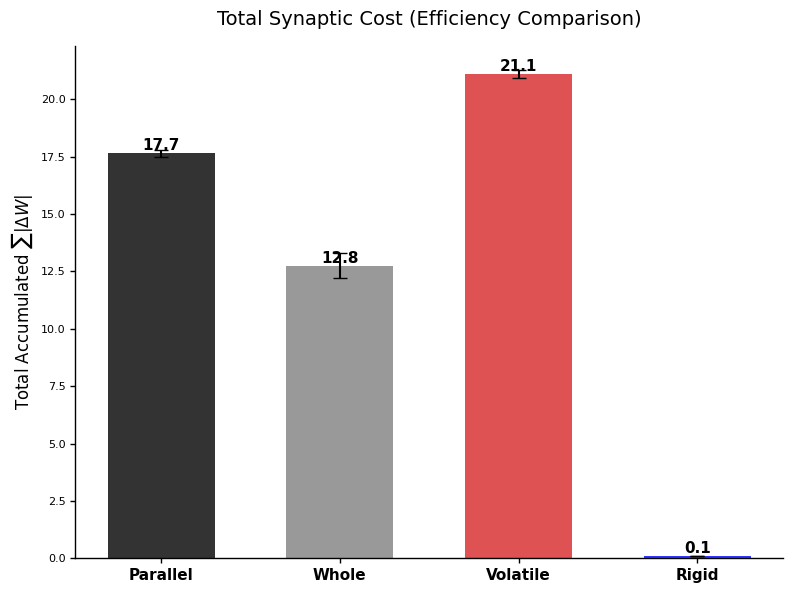

In [ ]:
# =========================================
# Cell 20: Total Synaptic Cost Comparison (Bar Graph)
# =========================================
# (Cell 19가 실행되어 'results' 변수가 메모리에 있다고 가정합니다)

import numpy as np
import matplotlib.pyplot as plt

# --- 1. Calculate Total Accumulated Delta W ---
# results 구조: results[model_name]["dw"] = [ [trace_seed1], [trace_seed2], ... ]

total_dw_means = []
total_dw_sems = []
labels = model_names  # ["Parallel", "Whole", "Volatile", "Rigid"]

print("[INFO] Calculating Total Synaptic Costs...")

for m in labels:
    # 1. 각 시드별로 Trace를 다 더함 (Sum over time)
    # dw_traces: (Num_Seeds, Num_Iters)
    dw_traces = np.array(results[m]["dw"])

    # 각 시드당 총 변화량 계산
    totals_per_seed = np.sum(dw_traces, axis=1)

    # 2. 평균 및 SEM 계산
    mean_val = np.mean(totals_per_seed)
    sem_val  = np.std(totals_per_seed) / np.sqrt(len(totals_per_seed))

    total_dw_means.append(mean_val)
    total_dw_sems.append(sem_val)

    print(f"  > {m:<10}: {mean_val:.4f} +/- {sem_val:.4f}")

# --- 2. Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

x_pos = np.arange(len(labels))
colors = ["black", "gray", "tab:red", "blue"] # Parallel, Whole, Volatile, Rigid

# Bar Plot
bars = ax.bar(x_pos, total_dw_means, yerr=total_dw_sems, capsize=5,
              color=colors, alpha=0.8, width=0.6)

# Aesthetics
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=11, fontweight='bold')
ax.set_ylabel("Total Accumulated $\sum |\Delta W|$", fontsize=12)
ax.set_title("Total Synaptic Cost (Efficiency Comparison)", fontsize=14, pad=15)

# Add numeric labels on top of bars
for bar, mean_val in zip(bars, total_dw_means):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height, f'{mean_val:.1f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Remove top/right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
save_pdf("20_Synaptic_Cost")
plt.show()

[INFO] Running P(Lick) Analysis (Slope=30.0)...
  > Model: Parallel   ... Done.
  > Model: Whole      ... Done.
  > Model: Volatile   ... Done.
  > Model: Rigid      ... Done.
  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/17_PLick_Dynamics_Comparison.pdf


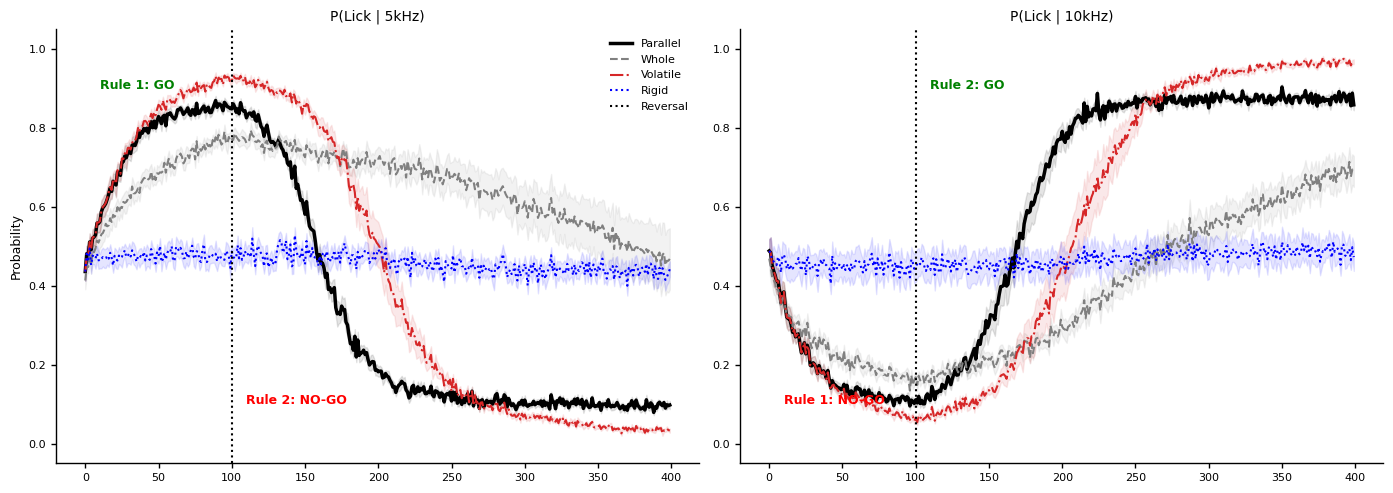

In [ ]:
# =========================================
# Cell 17: P(Lick) Dynamics Comparison
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. Experiment Setup ---
COMPARE_ITERS  = 400
COMPARE_SWITCH = 100
COMPARE_SEEDS  = list(range(10))

# --- 2. Define Baselines ---
class ConstantPPC:
    def __init__(self, g=1.0, f=0.0): self.g, self.f = g, f
    def update(self, *args, **kwargs): return self.g, self.f, 0.0, 0.0

MODELS = {
    "Parallel": ParallelPPC,
    "Whole": WholePPC,
    "Volatile": lambda: ConstantPPC(1.0, 1.0),
    "Rigid":    lambda: ConstantPPC(1.0, 0.00001)
}

print(f"[INFO] Running P(Lick) Analysis (Slope={SimConfig.PPC_SIGMOID_SLOPE})...")

# Data Containers: Separate P(Lick) for 5kHz and 10kHz
res_p5  = {k: [] for k in MODELS}
res_p10 = {k: [] for k in MODELS}

for m_name, m_class in MODELS.items():
    print(f"  > Model: {m_name:<10} ...", end="")
    for sd in COMPARE_SEEDS:
        SimConfig.STIM_SIGMA = 0.15
        torch.manual_seed(sd)

        net = FlexStableMLP().to(device)
        ctrl = m_class()
        anchor = clone_state_dict(net)

        trace_p5 = []
        trace_p10 = []
        r_ema = 0.0

        for t in range(COMPARE_ITERS):
            phase = 1 if t < COMPARE_SWITCH else 2

            # Generate batch (y=0 -> 5kHz, y=1 -> 10kHz based on generator logic)
            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)
            go_label = 0 if phase == 1 else 1

            # 1. Forward & Update Control
            with torch.no_grad():
                logits, _, _, _ = net(X, 0.8, 1.0)
                a1 = torch.distributions.Categorical(logits=logits).sample()
                h=((y==go_label)&(a1==0)).sum().item(); m=((y==go_label)&(a1==1)).sum().item()
                f=((y!=go_label)&(a1==0)).sum().item(); c=((y!=go_label)&(a1==1)).sum().item()
                gain, flex, _, _ = ctrl.update(0.0, [h,m,f,c], phase)

            # 2. Training
            logits2, _, _, _ = net(X, gain, 1.0)
            dist2 = torch.distributions.Categorical(logits=logits2)
            a2 = dist2.sample() # 0=Lick, 1=NoLick

            r = torch.where((y==go_label)&(a2==0), SimConfig.REWARD_GO,
                            torch.where((y!=go_label)&(a2==0), SimConfig.PENALTY_FA, 0.0))

            loss = -((r - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()
            net.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
            meta_update(net, anchor, build_flexibility_map(net, icro_flex=flex))

            r_ema = 0.95*r_ema + 0.05*r.mean().item()

            # 3. Measure P(Lick)
            # Mask for 5kHz trials (y==0) and 10kHz trials (y==1)
            # Action 0 is Lick
            with torch.no_grad():
                p_lick_5  = (a2[y==0] == 0).float().mean().item()
                p_lick_10 = (a2[y==1] == 0).float().mean().item()

            trace_p5.append(p_lick_5)
            trace_p10.append(p_lick_10)

        res_p5[m_name].append(trace_p5)
        res_p10[m_name].append(trace_p10)
    print(" Done.")

# --- 4. Visualization ---
def ms(d): d=np.array(d); return np.mean(d,0), np.std(d,0)/np.sqrt(d.shape[0])
colors = {"Parallel": "black", "Whole": "gray", "Rigid": "blue", "Volatile": "tab:red"}
styles = {"Parallel": "-", "Whole": "--", "Rigid": ":", "Volatile": "-."}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: P(Lick | 5kHz) - Rule 1 Target
ax = axes[0]
for m in MODELS:
    mu, se = ms(res_p5[m])
    ax.plot(mu, label=m, color=colors[m], ls=styles[m], lw=2.5 if m=="Parallel" else 1.5)
    ax.fill_between(range(len(mu)), mu-se, mu+se, color=colors[m], alpha=0.1)

ax.axvline(COMPARE_SWITCH, color='k', ls=':', label="Reversal")
ax.set_title("P(Lick | 5kHz)")
ax.set_ylabel("Probability")
ax.set_ylim(-0.05, 1.05)
ax.text(10, 0.9, "Rule 1: GO", color='green', fontweight='bold')
ax.text(COMPARE_SWITCH+10, 0.1, "Rule 2: NO-GO", color='red', fontweight='bold')
ax.legend(frameon=False)

# Plot 2: P(Lick | 10kHz) - Rule 2 Target
ax = axes[1]
for m in MODELS:
    mu, se = ms(res_p10[m])
    ax.plot(mu, label=m, color=colors[m], ls=styles[m], lw=2.5 if m=="Parallel" else 1.5)
    ax.fill_between(range(len(mu)), mu-se, mu+se, color=colors[m], alpha=0.1)

ax.axvline(COMPARE_SWITCH, color='k', ls=':')
ax.set_title("P(Lick | 10kHz)")
ax.set_ylim(-0.05, 1.05)
ax.text(10, 0.1, "Rule 1: NO-GO", color='red', fontweight='bold')
ax.text(COMPARE_SWITCH+10, 0.9, "Rule 2: GO", color='green', fontweight='bold')

plt.tight_layout()
# [SAVE PDF]
save_pdf("17_PLick_Dynamics_Comparison")
plt.show()

  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/17_PLick_Separated_Comparison.pdf


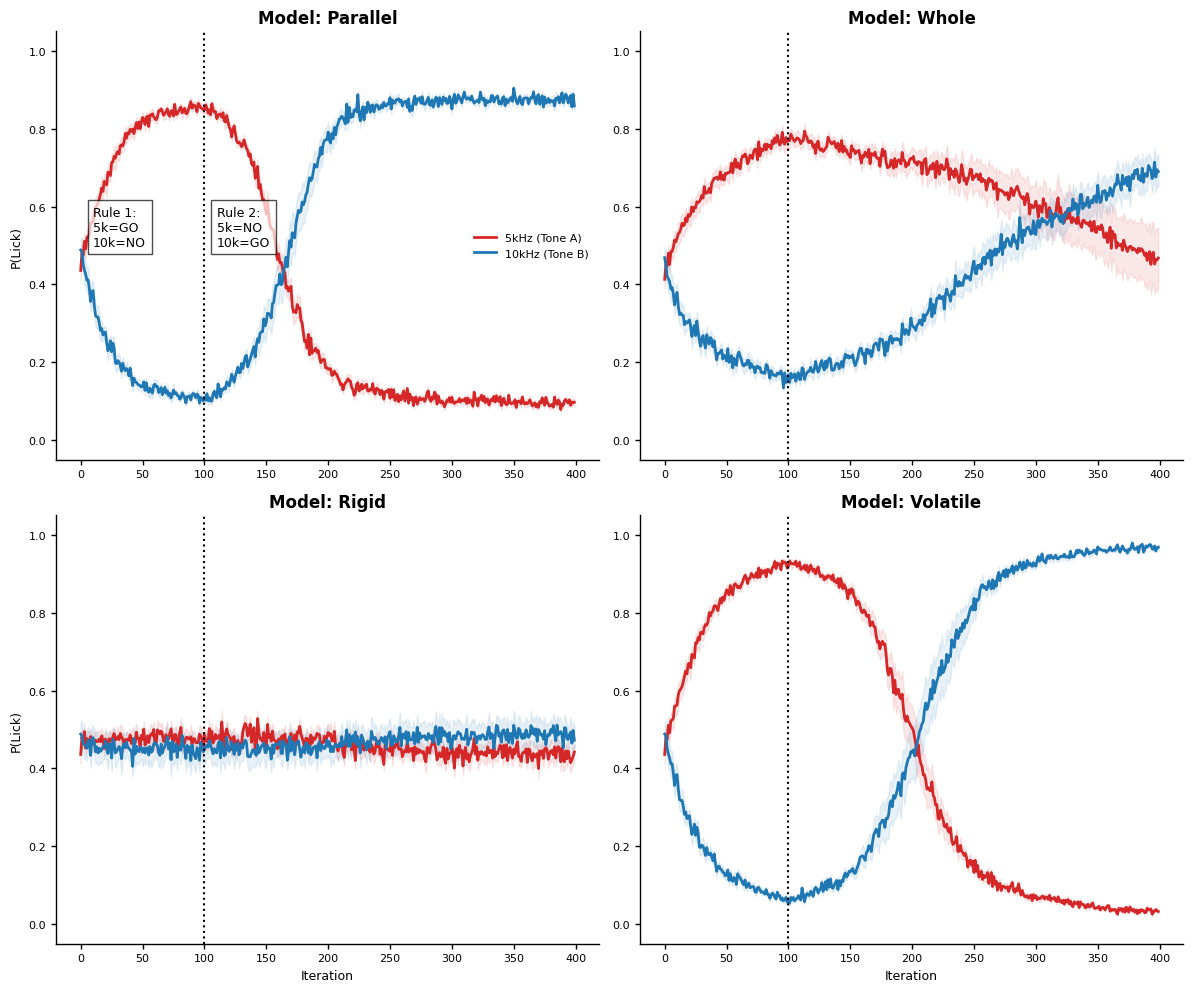

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() # 1D array로 변환

# 순서: Parallel -> Whole -> Rigid -> Volatile
model_order = ["Parallel", "Whole", "Rigid", "Volatile"]

for i, m_name in enumerate(model_order):
    ax = axes[i]

    # 5kHz Data (Red)
    mu5, se5 = ms(res_p5[m_name])
    ax.plot(mu5, label='5kHz (Tone A)', color='tab:red', lw=2)
    ax.fill_between(range(len(mu5)), mu5-se5, mu5+se5, color='tab:red', alpha=0.1)

    # 10kHz Data (Blue)
    mu10, se10 = ms(res_p10[m_name])
    ax.plot(mu10, label='10kHz (Tone B)', color='tab:blue', lw=2)
    ax.fill_between(range(len(mu10)), mu10-se10, mu10+se10, color='tab:blue', alpha=0.1)

    # Annotations
    ax.set_title(f"Model: {m_name}", fontsize=12, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.axvline(COMPARE_SWITCH, color='k', ls=':', lw=1.5)

    if i == 0: # Legend only on first plot
        ax.legend(loc='center right', frameon=False)
        ax.text(10, 0.5, "Rule 1:\n5k=GO\n10k=NO", fontsize=9, bbox=dict(facecolor='white', alpha=0.7))
        ax.text(COMPARE_SWITCH+10, 0.5, "Rule 2:\n5k=NO\n10k=GO", fontsize=9, bbox=dict(facecolor='white', alpha=0.7))

    # X, Y Labels
    if i >= 2: ax.set_xlabel("Iteration")
    if i % 2 == 0: ax.set_ylabel("P(Lick)")

plt.tight_layout()
save_pdf("17_PLick_Separated_Comparison")
plt.show()

[INFO] Collecting Stats (Hit/FA, Internal, TTR)...
  > Model: Parallel   ... Done.
  > Model: Whole      ... Done.
  > Model: Volatile   ... Done.
  > Model: Rigid      ... Done.
  >>> [SAVED PDF] /content/drive/My Drive/Neuro_Sim_Results/Final_PDFs/17-2_Supplementary_Analysis_with_TTR.pdf


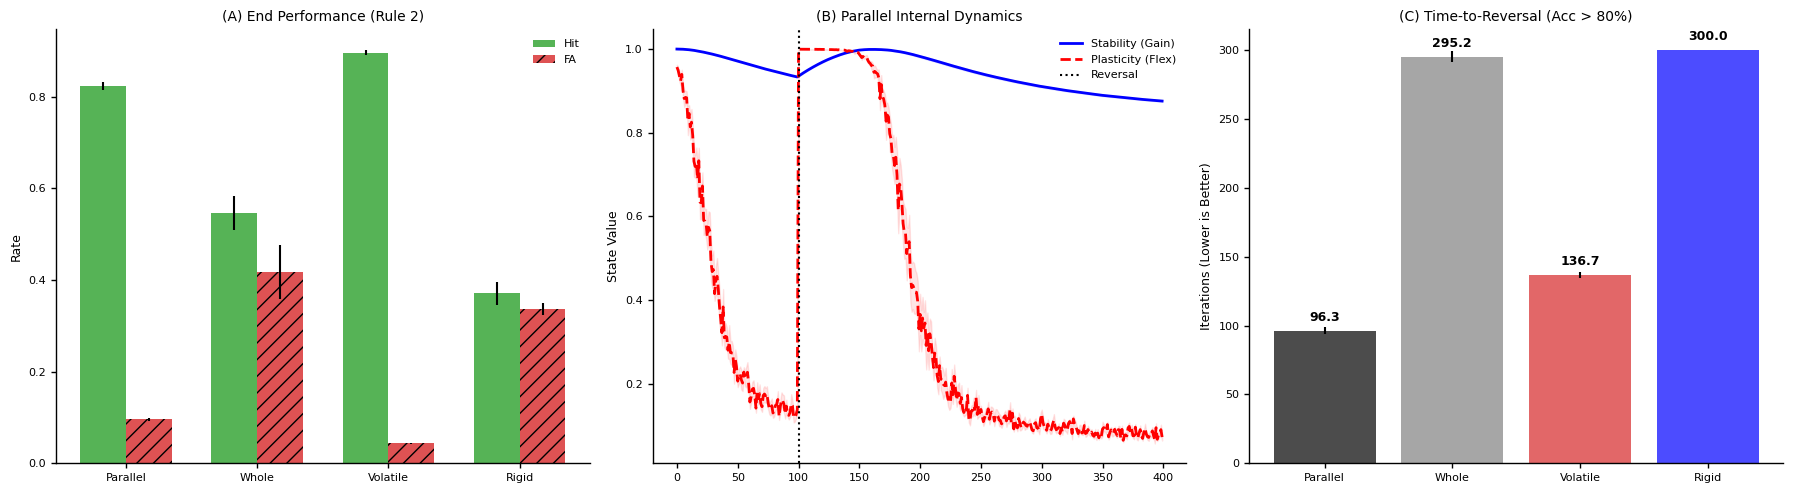

In [ ]:
# =========================================
# Cell 17-2: Supplementary Analysis (Restoring Fig 2 + TTR)
# =========================================
# Goal: Collect Hit/FA, Internal States, and TTR (Time-to-Reversal)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import torch

# --- 1. Define Baselines ---
class ConstantPPC:
    def __init__(self, g=1.0, f=0.0): self.g, self.f = g, f
    def update(self, *args, **kwargs): return self.g, self.f, 0.0, 0.0

MODELS = {
    "Parallel": ParallelPPC,
    "Whole": WholePPC,
    "Volatile": lambda: ConstantPPC(1.0, 1.0),
    "Rigid":    lambda: ConstantPPC(1.0, 0.00001)
}

# --- 2. Quick Run for Stats ---
COMPARE_ITERS  = 400
COMPARE_SWITCH = 100
DIAG_SEEDS     = list(range(10))
TTR_THRESHOLD  = 0.8  # 정답률 80% 도달 기준

print(f"[INFO] Collecting Stats (Hit/FA, Internal, TTR)...")

stats_r2 = {k: {"hit": [], "fa": []} for k in MODELS}
ttr_stats = {k: [] for k in MODELS} # [NEW] TTR 저장소
parallel_traces = {"ic_gain": [], "ac_flex": []}

for m_name, m_class in MODELS.items():
    print(f"  > Model: {m_name:<10} ...", end="")
    for sd in DIAG_SEEDS:
        SimConfig.STIM_SIGMA = 0.15
        torch.manual_seed(sd)

        net = FlexStableMLP().to(device)
        ctrl = m_class()
        anchor = clone_state_dict(net)

        seed_hit, seed_fa, seed_gain, seed_flex = [], [], [], []
        r_ema = 0.0

        # TTR 관련 변수
        found_reversal = False
        ttr_val = COMPARE_ITERS - COMPARE_SWITCH # 못 찾으면 최대값(300)

        for t in range(COMPARE_ITERS):
            phase = 1 if t < COMPARE_SWITCH else 2
            X, y = generate_mixed_batch(SimConfig.BATCH_SIZE, SimConfig.STIM_SIGMA)
            X, y = X.to(device), y.to(device)
            go_label = 0 if phase == 1 else 1

            # Forward
            with torch.no_grad():
                logits, _, _, _ = net(X, 0.8, 1.0)
                a1 = torch.distributions.Categorical(logits=logits).sample()
                h=((y==go_label)&(a1==0)).sum().item(); m=((y==go_label)&(a1==1)).sum().item()
                f=((y!=go_label)&(a1==0)).sum().item(); c=((y!=go_label)&(a1==1)).sum().item()
                gain, flex, _, _ = ctrl.update(0.0, [h,m,f,c], phase)

            # Save Traces (Parallel Only)
            if m_name == "Parallel":
                seed_gain.append(gain)
                seed_flex.append(flex)

            # Training
            logits2, _, _, _ = net(X, gain, 1.0)
            dist2 = torch.distributions.Categorical(logits=logits2); a2 = dist2.sample()
            r = torch.where((y==go_label)&(a2==0), SimConfig.REWARD_GO, torch.where((y!=go_label)&(a2==0), SimConfig.PENALTY_FA, 0.0))
            loss = -((r - r_ema) * dist2.log_prob(a2)).mean() - SimConfig.ENTROPY_BETA * dist2.entropy().mean()
            net.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(net.parameters(), 5.0)
            meta_update(net, anchor, build_flexibility_map(net, icro_flex=flex))

            r_ema = 0.95*r_ema + 0.05*r.mean().item()

            # Calc Hit/FA
            cur_hit = h / (h + m + 1e-6)
            cur_fa  = f / (f + c + 1e-6)
            seed_hit.append(cur_hit)
            seed_fa.append(cur_fa)

            # [NEW] Calculate TTR
            if phase == 2 and not found_reversal:
                # 현재 배치의 정확도 계산
                cur_acc = ((y==go_label)&(a2==0)).float().sum() + ((y!=go_label)&(a2==1)).float().sum()
                cur_acc = cur_acc.item() / X.shape[0]

                # 기준(0.8)을 넘으면 TTR 확정
                if cur_acc >= TTR_THRESHOLD:
                    ttr_val = t - COMPARE_SWITCH
                    found_reversal = True

        # End of Seed Loop
        stats_r2[m_name]["hit"].append(np.mean(seed_hit[-50:]))
        stats_r2[m_name]["fa"].append(np.mean(seed_fa[-50:]))
        ttr_stats[m_name].append(ttr_val)

        if m_name == "Parallel":
            parallel_traces["ic_gain"].append(seed_gain)
            parallel_traces["ac_flex"].append(seed_flex)

    print(" Done.")

# --- 3. Visualization (Fig 2 + TTR) ---
def ms(d): d=np.array(d); return np.mean(d,0), np.std(d,0)/np.sqrt(d.shape[0])
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1x3 Layout

# (A) Rule 2 End Performance
ax = axes[0]
x = np.arange(len(MODELS)); width = 0.35
mh = [ms(stats_r2[m]["hit"])[0] for m in MODELS]; sh = [ms(stats_r2[m]["hit"])[1] for m in MODELS]
mf = [ms(stats_r2[m]["fa"])[0] for m in MODELS]; sf = [ms(stats_r2[m]["fa"])[1] for m in MODELS]

ax.bar(x - width/2, mh, width, yerr=sh, label='Hit', color='tab:green', alpha=0.8)
ax.bar(x + width/2, mf, width, yerr=sf, label='FA', color='tab:red', alpha=0.8, hatch='//')
ax.set_xticks(x); ax.set_xticklabels(MODELS.keys())
ax.set_title("(A) End Performance (Rule 2)")
ax.set_ylabel("Rate"); ax.legend(frameon=False)

# (B) Parallel Internal Dynamics
ax = axes[1]
def pt(data, col, lab, ls):
    arr = np.array(data); m = arr.mean(0); s = arr.std(0)/np.sqrt(arr.shape[0])
    ax.plot(m, color=col, label=lab, ls=ls, lw=2)
    ax.fill_between(range(len(m)), m-s, m+s, color=col, alpha=0.1)

pt(parallel_traces["ic_gain"], "blue", "Stability (Gain)", "-")
pt(parallel_traces["ac_flex"], "red", "Plasticity (Flex)", "--")

ax.axvline(COMPARE_SWITCH, color='k', ls=':', label="Reversal")
ax.set_title("(B) Parallel Internal Dynamics")
ax.set_ylabel("State Value"); ax.legend(frameon=False)

# (C) [NEW] Time-to-Reversal (TTR)
ax = axes[2]
ttr_means = [ms(ttr_stats[m])[0] for m in MODELS]
ttr_sems  = [ms(ttr_stats[m])[1] for m in MODELS]
colors = ["black", "gray", "tab:red", "blue"] # Parallel, Whole, Volatile, Rigid

bars = ax.bar(MODELS.keys(), ttr_means, yerr=ttr_sems, color=colors, alpha=0.7)
ax.set_title("(C) Time-to-Reversal (Acc > 80%)")
ax.set_ylabel("Iterations (Lower is Better)")

# Add values on top
for b, v in zip(bars, ttr_means):
    ax.text(b.get_x()+b.get_width()/2, v + 5, f"{v:.1f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
save_pdf("17-2_Supplementary_Analysis_with_TTR")
plt.show()